In [326]:
import unittest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import io
import sys
import plotly.express as px

from unittest.mock import patch
from IPython.display import display


plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [327]:
df = pd.read_csv('belanjakita.csv')
df.head()

,transaction_id,transaction_date,customer_name,customer_city,product_category,product_name,unit_price,quantity,total_amount,payment_method,delivery_status,merchant_name
0,TRX-10001,2025-06-11,ANDI SAPUTRA,surabaya,fashion,Kaos Polos,6473388,10,64733880.0,Ewallet,Delivered,BeautyHub
1,TRX-10002,21-03-2025,Andi Saputra,jakarta,Fashion,Laptop Asus,2284489,1,2284489.0,Card,delivered,GadgetMart
2,TRX-10003,14/05/2025,NANDA PRATAMA,Surabaya,aksesoris,Vacuum Cleaner,9574682,10,95746820.0,COD,Pending,SportMax
3,TRX-10004,2025/06/25,Budi Santoso,Medan,Kecantican,Lipstik Wardah,9678519,10,96785190.0,Card,Returned,BeautyHub
4,TRX-10005,2025-07-09,Mega Putri,NaN,Acsesoris,Laptop Asus,4573669,2,9147338.0,Transfer,NaN,TrendShop


In [328]:
# buat formater rupiah
def format_rupiah(x):
    try:
        return f"Rp{int(x):,}".replace(",", ".")
    except:
        return x

# Cleansing Dataset

In [329]:
# Buat copy dataframe untuk cleaning
df = df.copy()

# Cek info dataset terlebih dahulu
print("=== INFO DATASET ===")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nSample data:")
df.head()
print(f"\nData types:")
df.dtypes

=== INFO DATASET ===
Shape: (5000, 12)
Columns: ['transaction_id', 'transaction_date', 'customer_name', 'customer_city', 'product_category', 'product_name', 'unit_price', 'quantity', 'total_amount', 'payment_method', 'delivery_status', 'merchant_name']

Sample data:

Data types:


transaction_id       object
transaction_date     object
customer_name        object
customer_city        object
product_category     object
product_name         object
unit_price            int64
quantity              int64
total_amount        float64
payment_method       object
delivery_status      object
merchant_name        object
dtype: object

In [330]:
# Cek format tanggal
if 'transaction_date' in df.columns:
    print(df['transaction_date'].head(10).tolist())

    # Baca ulang dari CSV untuk mendapatkan format asli
    df_temp = pd.read_csv('belanjakita.csv')
    print(df_temp['transaction_date'].head(10).tolist())

    # Fungsi untuk parse berbagai format tanggal
    def parse_date(date_str):
        if pd.isna(date_str) or str(date_str).lower() in ['nan', 'null', '']:
            return pd.NaT

        date_str = str(date_str).strip()

        # Daftar format tanggal
        date_formats = [
            '%d-%m-%Y',    # 01-12-2023
            '%d/%m/%Y',    # 01/12/2023
            '%d.%m.%Y',    # 01.12.2023
            '%Y-%m-%d',    # 2023-12-01
            '%Y/%m/%d',    # 2023/12/01
            '%m-%d-%Y',    # 12-01-2023
            '%m/%d/%Y',    # 12/01/2023
            '%d-%m-%y',    # 01-12-23
            '%d/%m/%y',    # 01/12/23
            '%Y-%m-%d %H:%M:%S',
            '%d-%m-%Y %H:%M:%S',
            '%d/%m/%Y %H:%M:%S'
        ]

        for fmt in date_formats:
            try:
                return pd.to_datetime(date_str, format=fmt)
            except:
                continue

        # Jika semua format gagal, coba dengan pandas inference
        try:
            return pd.to_datetime(date_str, dayfirst=True)
        except:
            try:
                return pd.to_datetime(date_str, dayfirst=False)
            except:
                return pd.NaT

    # Apply fungsi parsing
    print("\nMembersihkan format tanggal...")
    df['transaction_date'] = df_temp['transaction_date'].apply(parse_date)

    # Cek hasil
    valid_dates = df['transaction_date'].notna().sum()
    total_dates = len(df)
    success_rate = (valid_dates / total_dates) * 100

    print(f"Berhasil diparse: {valid_dates:,} dari {total_dates:,} ({success_rate:.1f}%)")
    print(f"Tanggal gagal diparse: {df['transaction_date'].isna().sum():,}")

    if valid_dates > 0:
        print(f"Range tanggal: {df['transaction_date'].min()} hingga {df['transaction_date'].max()}")
        print("\nSample tanggal setelah cleaning:")
        print(df['transaction_date'].dropna().head(10).tolist())

else:
    print("Kolom transaction_date tidak ditemukan!")

['2025-06-11', '21-03-2025', '14/05/2025', '2025/06/25', '2025-07-09', '2025/03/02', '2025/07/08', '08/08/2025', '2025/05/28', '2025/03/15']
['2025-06-11', '21-03-2025', '14/05/2025', '2025/06/25', '2025-07-09', '2025/03/02', '2025/07/08', '08/08/2025', '2025/05/28', '2025/03/15']

Membersihkan format tanggal...
Berhasil diparse: 5,000 dari 5,000 (100.0%)
Tanggal gagal diparse: 0
Range tanggal: 2025-03-01 00:00:00 hingga 2025-08-27 00:00:00

Sample tanggal setelah cleaning:
[Timestamp('2025-06-11 00:00:00'), Timestamp('2025-03-21 00:00:00'), Timestamp('2025-05-14 00:00:00'), Timestamp('2025-06-25 00:00:00'), Timestamp('2025-07-09 00:00:00'), Timestamp('2025-03-02 00:00:00'), Timestamp('2025-07-08 00:00:00'), Timestamp('2025-08-08 00:00:00'), Timestamp('2025-05-28 00:00:00'), Timestamp('2025-03-15 00:00:00')]


In [331]:
# Mapping untuk product_category
mapping_kategori = {
    'Ascesoris': 'Aksesoris',
    'aksesoris': 'Aksesoris',
    'Aksesoris': 'Aksesoris',
    'Aksesoriss': 'Aksesoris',
    'Acsesoris': 'Aksesoris',
    'Electronic': 'Elektronik',
    'elektronik': 'Elektronik',
    'Elektroniks': 'Elektronik',
    'fashion': 'Fashion',
    'Fashions': 'Fashion',
    'Kecantican': 'Kecantikan',
    'kecantikan': 'Kecantikan',
    'Kecantikans': 'Kecantikan',
    'Macanan': 'Makanan',
    'Makanan': 'Makanan',
    'Makanans': 'Makanan',
    'olahraga': 'Olahraga',
    'Olahragas': 'Olahraga',
    'rumah tangga': 'Rumah Tangga',
    'Rumah Tanggas': 'Rumah Tangga'
}

# Mapping untuk customer_city
mapping_kota = {
    'Ban': 'Bandung',
    'Bandung': 'Bandung',
    'Bendung': 'Bandung',
    'Den': 'Denpasar',
    'Denpasar': 'Denpasar',
    'Denpeser': 'Denpasar',
    'Jak': 'Jakarta',
    'jakarta': 'Jakarta',
    'Jekerte': 'Jakarta',
    'Mak': 'Makassar',
    'makassar': 'Makassar',
    'Mekesser': 'Makassar',
    'Med': 'Medan',
    'Medan': 'Medan',
    'Meden': 'Medan',
    'Sur': 'Surabaya',
    'surabaya': 'Surabaya',
    'Surebeye': 'Surabaya',
    'Yog': 'Yogyakarta',
    'Yogyakarta': 'Yogyakarta',
    'Yogyekerte': 'Yogyakarta',
    'NaN': 'Unknown',
    '': 'Unknown'
}

# Mapping untuk delivery_status
mapping_delivery_status = {
    'Canceled': 'Canceled',
    'Delivered': 'Delivered',
    'Pending': 'Pending',
    'Returned': 'Returned',
    '(Kosong)': 'Unknown',
    '': 'Unknown'
}

# Mapping untuk payment_method
mapping_payment_method = {
    'Card': 'Kartu Kredit',
    'Kartu Kredit': 'Kartu Kredit',
    'COD': 'COD',
    'Ewallet': 'E-Wallet',
    'E-Wallet': 'E-Wallet',
    'Transfer': 'Transfer',
    '(Kosong)': 'Unknown',
    '': 'Unknown'
}

mapping_product_category = {
    '': 'Unknown',
    'Nan': 'Unknown',
    'NaN': 'Unknown'
}

# Cek nilai unik sebelum mapping
print("=== SEBELUM MAPPING ===")
if 'product_category' in df.columns:
    print(f"Product Category: {df['product_category'].value_counts()}")
if 'customer_city' in df.columns:
    print(f"\nCustomer City: {df['customer_city'].value_counts()}")
if 'delivery_status' in df.columns:
    print(f"\nDelivery Status: {df['delivery_status'].value_counts()}")
if 'payment_method' in df.columns:
    print(f"\nPayment Method: {df['payment_method'].value_counts()}")
if 'product_category' in df.columns:
    print(f"\nProduct Category: {df['product_category'].value_counts()}")

if 'product_category' in df.columns:
    df['product_category'] = df['product_category'].fillna('').map(mapping_kategori).fillna(df['product_category']).str.title()
    print("✓ Product category berhasil dimapping")

if 'customer_city' in df.columns:
    df['customer_city'] = df['customer_city'].fillna('').map(mapping_kota).fillna(df['customer_city']).str.title()
    print("✓ Customer city berhasil dimapping")

if 'delivery_status' in df.columns:
    df['delivery_status'] = df['delivery_status'].fillna('').map(mapping_delivery_status).fillna(df['delivery_status']).str.title()
    print("✓ Delivery status berhasil dimapping")

if 'payment_method' in df.columns:
    df['payment_method'] = df['payment_method'].fillna('').map(mapping_payment_method).fillna(df['payment_method']).str.title()
    print("✓ Payment method berhasil dimapping")
if 'product_category' in df.columns:
    df['product_category'] = df['product_category'].fillna('').map(mapping_product_category).fillna(df['product_category']).str.title()
    print("✓ Product category berhasil dimapping")
    
# Tambahkan mapping untuk customer_name dan kolom lain yang perlu title case
if 'customer_name' in df.columns:
    df['customer_name'] = df['customer_name'].str.title()
    print("✓ Customer name berhasil diformat ke title case")

if 'product_name' in df.columns:
    df['product_name'] = df['product_name'].str.title()
    print("✓ Product name berhasil diformat ke title case")

if 'merchant_name' in df.columns:
    df['merchant_name'] = df['merchant_name'].str.title()
    print("✓ Merchant name berhasil diformat ke title case")

=== SEBELUM MAPPING ===
Product Category: product_category
Fashion          363
Rumah Tangga     334
Olahraga         325
elektronik       193
Electronic       191
Aksesoriss       189
Macanan          182
Elektronik       182
Kecantican       179
Kecantikans      178
Makanans         178
Fashions         176
Rumah Tanggas    175
makanan          172
Makanan          172
aksesoris        172
Aksesoris        169
olahraga         167
fashion          158
Kecantikan       157
Acsesoris        156
rumah tangga     152
Elektroniks      150
kecantikan       144
Olahragas        136
Name: count, dtype: int64

Customer City: customer_city
Yogyekerte    197
Jakarta       196
Jak           188
surabaya      185
Jekerte       183
Medan         181
medan         179
jakarta       176
Den           176
Denpeser      173
bandung       171
yogyakarta    171
denpasar      169
Mekesser      168
Bendung       168
Ban           167
Meden         167
Surabaya      166
makassar      165
Med           164


In [332]:
# Cek hasil setelah mapping
print("\n=== SETELAH MAPPING ===")
if 'product_category' in df.columns:
    print(f"Product Category: {df['product_category'].value_counts()}")
if 'customer_city' in df.columns:
    print(f"\nCustomer City: {df['customer_city'].value_counts()}")
if 'delivery_status' in df.columns:
    print(f"\nDelivery Status: {df['delivery_status'].value_counts()}")
if 'payment_method' in df.columns:
    print(f"\nPayment Method: {df['payment_method'].value_counts()}")


=== SETELAH MAPPING ===
Product Category: product_category
Elektronik      716
Makanan         704
Fashion         697
Aksesoris       686
Rumah Tangga    661
Kecantikan      658
Olahraga        628
Unknown         250
Name: count, dtype: int64

Customer City: customer_city
Jakarta       743
Medan         691
Denpasar      680
Yogyakarta    675
Bandung       663
Surabaya      661
Makassar      637
Unknown       250
Name: count, dtype: int64

Delivery Status: delivery_status
Delivered    1598
Pending      1551
Canceled      812
Returned      789
Unknown       250
Name: count, dtype: int64

Payment Method: payment_method
Kartu Kredit    1583
E-Wallet        1582
Transfer         803
Cod              782
Unknown          250
Name: count, dtype: int64


## Total data unknown

=== TOTAL DATA UNKNOWN PER KOLOM ===
PRODUCT_CATEGORY:
  - Total Unknown: 250
  - Total Data: 5,000
  - Persentase Unknown: 5.00%

CUSTOMER_CITY:
  - Total Unknown: 250
  - Total Data: 5,000
  - Persentase Unknown: 5.00%

DELIVERY_STATUS:
  - Total Unknown: 250
  - Total Data: 5,000
  - Persentase Unknown: 5.00%

PAYMENT_METHOD:
  - Total Unknown: 250
  - Total Data: 5,000
  - Persentase Unknown: 5.00%

=== SUMMARY TABLE ===
                  total_unknown  total_data persentase_formatted
product_category          250.0      5000.0                5.00%
customer_city             250.0      5000.0                5.00%
delivery_status           250.0      5000.0                5.00%
payment_method            250.0      5000.0                5.00%


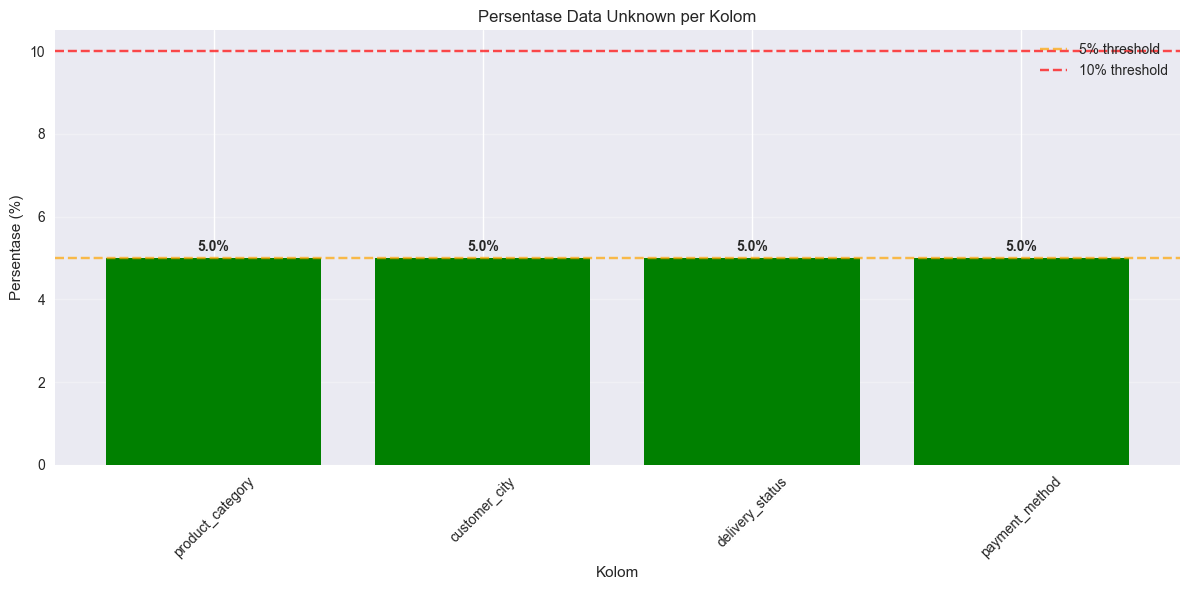

In [333]:
# Hitung total data unknown per kolom
print("=== TOTAL DATA UNKNOWN PER KOLOM ===")

# Daftar kolom yang ingin dicek
kolom_kategori = ['product_category', 'customer_city', 'delivery_status', 'payment_method']

unknown_summary = {}

for kolom in kolom_kategori:
    if kolom in df.columns:
        # Hitung jumlah unknown/kosong
        unknown_count = df[kolom].isin(['Unknown', '', 'Nan', 'NaN']).sum()
        null_count = df[kolom].isna().sum()
        total_unknown = unknown_count + null_count
        total_data = len(df)
        persentase = (total_unknown / total_data) * 100
        
        unknown_summary[kolom] = {
            'total_unknown': total_unknown,
            'total_data': total_data,
            'persentase': persentase
        }
        
        print(f"{kolom.upper()}:")
        print(f"  - Total Unknown: {total_unknown:,}")
        print(f"  - Total Data: {total_data:,}")
        print(f"  - Persentase Unknown: {persentase:.2f}%")
        print()

# Buat summary table
print("=== SUMMARY TABLE ===")
summary_df = pd.DataFrame(unknown_summary).T
summary_df['persentase_formatted'] = summary_df['persentase'].apply(lambda x: f"{x:.2f}%")

print(summary_df[['total_unknown', 'total_data', 'persentase_formatted']])

# Visualisasi persentase unknown data
plt.figure(figsize=(12, 6))
bars = plt.bar(summary_df.index, summary_df['persentase'], 
               color=['red' if x > 10 else 'orange' if x > 5 else 'green' for x in summary_df['persentase']])
plt.title('Persentase Data Unknown per Kolom')
plt.ylabel('Persentase (%)')
plt.xlabel('Kolom')
plt.xticks(rotation=45)

# Tambahkan nilai di atas bar
for bar, pct in zip(bars, summary_df['persentase']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

# Tambahkan garis referensi
plt.axhline(y=5, color='orange', linestyle='--', alpha=0.7, label='5% threshold')
plt.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='10% threshold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [334]:
# Fixing product_name dan product_category menggunakan mapping manual

# 1. Cek duplikasi product_name dengan kategori berbeda sebelum fixing
duplikasi_sebelum = df.groupby('product_name')['product_category'].nunique()
produk_beda_kategori_sebelum = duplikasi_sebelum[duplikasi_sebelum > 1]

print(f"Jumlah produk dengan kategori berbeda sebelum fixing: {len(produk_beda_kategori_sebelum)}")

# 2. Manual mapping berdasarkan yang kamu tentukan
product_category_mapping = {
    'Kaos Polos': 'Fashion',
    'Laptop Asus': 'Elektronik', 
    'Vacuum Cleaner': 'Elektronik',
    'Lipstik Wardah': 'Kecantikan',
    'Smartwatch': 'Elektronik',
    'Powerbank 10K': 'Elektronik',
    'Headphone Jbl': 'Elektronik',
    'Sepatu Nike': 'Fashion'
}

# 3. Apply manual mapping
print("\nMenerapkan mapping manual...")
fixes_made = 0
for product_name, correct_category in product_category_mapping.items():
    mask = df['product_name'] == product_name
    if mask.any():
        old_categories = df.loc[mask, 'product_category'].unique()
        df.loc[mask, 'product_category'] = correct_category
        fixes_applied = mask.sum()
        fixes_made += fixes_applied
        
        print(f"✓ {product_name}: {old_categories} → {correct_category} ({fixes_applied} records)")

print(f"\nTotal records yang difix: {fixes_made:,}")

# 4. Cek duplikasi setelah manual fixing
duplikasi_setelah = df.groupby('product_name')['product_category'].nunique()
produk_beda_kategori_setelah = duplikasi_setelah[duplikasi_setelah > 1]

print(f"\n=== HASIL SETELAH MANUAL FIXING ===")
print(f"Produk dengan kategori berbeda setelah fixing: {len(produk_beda_kategori_setelah)}")

if len(produk_beda_kategori_setelah) > 0:
    print("\nProduk yang masih punya kategori berbeda:")
    for produk in produk_beda_kategori_setelah.index[:10]:
        kategori_list = df[df['product_name'] == produk]['product_category'].unique()
        count_per_kategori = df[df['product_name'] == produk]['product_category'].value_counts()
        print(f"  {produk}: {kategori_list}")
        print(f"    Count: {dict(count_per_kategori)}")
else:
    print("✓ Semua produk sudah punya kategori yang konsisten!")

# 5. Summary kategori setelah fixing
print(f"\n=== SUMMARY KATEGORI SETELAH FIXING ===")
kategori_final = df['product_category'].value_counts()
print(kategori_final)

# 6. Tampilkan sample produk per kategori untuk verifikasi
print(f"\n=== VERIFIKASI SAMPLE PRODUK PER KATEGORI ===")
for kategori in kategori_final.index:
    if kategori != 'Unknown':
        sample_produk = df[df['product_category'] == kategori]['product_name'].unique()[:5]
        print(f"\n{kategori}:")
        for produk in sample_produk:
            print(f"  - {produk}")

Jumlah produk dengan kategori berbeda sebelum fixing: 8

Menerapkan mapping manual...
✓ Kaos Polos: ['Fashion' 'Makanan' 'Elektronik' 'Aksesoris' 'Kecantikan' 'Rumah Tangga'
 'Unknown' 'Olahraga'] → Fashion (654 records)
✓ Laptop Asus: ['Fashion' 'Aksesoris' 'Olahraga' 'Rumah Tangga' 'Unknown' 'Makanan'
 'Elektronik' 'Kecantikan'] → Elektronik (619 records)
✓ Vacuum Cleaner: ['Aksesoris' 'Rumah Tangga' 'Kecantikan' 'Olahraga' 'Unknown' 'Elektronik'
 'Makanan' 'Fashion'] → Elektronik (621 records)
✓ Lipstik Wardah: ['Kecantikan' 'Makanan' 'Rumah Tangga' 'Elektronik' 'Unknown' 'Olahraga'
 'Aksesoris' 'Fashion'] → Kecantikan (619 records)
✓ Smartwatch: ['Makanan' 'Fashion' 'Olahraga' 'Elektronik' 'Aksesoris' 'Rumah Tangga'
 'Kecantikan' 'Unknown'] → Elektronik (658 records)
✓ Powerbank 10K: ['Rumah Tangga' 'Kecantikan' 'Fashion' 'Elektronik' 'Aksesoris' 'Makanan'
 'Olahraga' 'Unknown'] → Elektronik (594 records)
✓ Headphone Jbl: ['Fashion' 'Makanan' 'Rumah Tangga' 'Kecantikan' 'Aksesoris'

# Nomor 1
“Ada laporan dari finance katanya total_amount gak selalu sama kayak harga dikali quantity. Tolong dicek ya, kira-kira kenapa bisa gitu.”

Statistik selisih (total_amount - new_total):


count    5.000000e+03
mean    -1.190945e+07
std      3.032880e+08
min     -1.587728e+10
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.754265e+08
Name: diff, dtype: float64

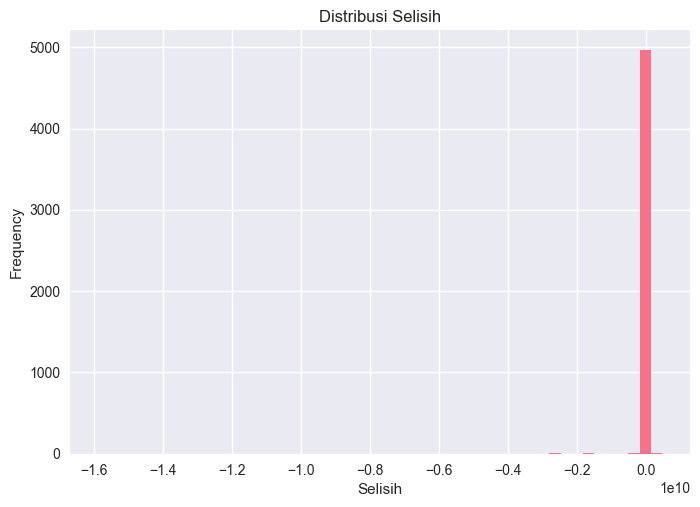

In [335]:
# Analisis selisih total_amount vs unit_price * quantity
df = df.copy()
df['new_total'] = df['unit_price'] * df['quantity']
df['diff'] = df['total_amount'] - df['new_total']

print("Statistik selisih (total_amount - new_total):")
display(df['diff'].describe())

# Visualisasi distribusi selisih
df['diff'].plot.hist(bins=50, title='Distribusi Selisih')
plt.xlabel('Selisih')
plt.show()

# Tabel baris dengan selisih signifikan
toleransi = 0.01 * df['new_total'] + 1000
tabel_selisih = df[abs(df['diff']) > toleransi].copy()
tabel_selisih['harga_per_item_asli'] = tabel_selisih['total_amount'] / tabel_selisih['quantity']

In [336]:
# 1. Ambil harga per item untuk qty==1
df_qty1 = df[df['quantity'] == 1][['product_name', 'unit_price']].copy()
df_qty1 = df_qty1.rename(columns={'unit_price': 'harga_per_item_qty1'})

# 2. Ambil harga per item asli untuk qty>1 (dan selisih signifikan)
df_qty_gt1 = df[(df['quantity'] > 1) & (abs(df['diff']) > toleransi)][['product_name', 'total_amount', 'quantity']].copy()
df_qty_gt1['harga_per_item_qty_gt1'] = df_qty_gt1['total_amount'] / df_qty_gt1['quantity']

# 3. Gabungkan dua tabel berdasarkan product_name
tabel_perbandingan = pd.merge(
    df_qty1.drop_duplicates('product_name'),
    df_qty_gt1.drop_duplicates('product_name'),
    on='product_name',
    how='inner'
)[['product_name', 'harga_per_item_qty1', 'harga_per_item_qty_gt1']]

# 4. Format rupiah
tabel_perbandingan['harga_per_item_qty1'] = tabel_perbandingan['harga_per_item_qty1'].apply(format_rupiah)
tabel_perbandingan['harga_per_item_qty_gt1'] = tabel_perbandingan['harga_per_item_qty_gt1'].apply(format_rupiah)

display(tabel_perbandingan)

total_transaksi_beda = len(df_qty_gt1)
total_selisih = df[(df['quantity'] > 1) & (abs(df['diff']) > toleransi)]['diff'].sum()

print(f"Total transaksi yang harganya beda dari seharusnya: {total_transaksi_beda}")
print(f"Total harga selisih: {format_rupiah(total_selisih)}")

,product_name,harga_per_item_qty1,harga_per_item_qty_gt1
0,Laptop Asus,Rp2.284.489,Rp2.289.439
1,Smartwatch,Rp3.325.709,Rp777.374
2,Lipstik Wardah,Rp8.292.680,Rp9.431.598
3,Powerbank 10K,Rp6.690.913,Rp4.927.181
4,Headphone Jbl,Rp5.047.895,Rp5.541.590
5,Kaos Polos,Rp6.299.859,Rp1.296.257
6,Vacuum Cleaner,Rp3.416.612,Rp8.356.461
7,Sepatu Nike,Rp9.959.709,Rp3.357.982


Total transaksi yang harganya beda dari seharusnya: 297
Total harga selisih: Rp-58.386.077.886


# Nomer 2
“Gue pengin tahu siapa aja customer yang paling sering belanja selama 6 bulan terakhir. Bisa di-rank dari yang paling aktif?”

=== TOP 10 CUSTOMER PALING AKTIF ===


,total_transaksi,total_belanja
customer_name,,
Mega Putri,709,Rp45.233.226.046
Ahmad Fauzi,636,Rp39.955.339.037
Siti Aminah,635,Rp38.261.531.087
Andi Saputra,629,Rp41.811.011.342
Nanda Pratama,617,Rp42.757.076.013
Budi Santoso,596,Rp39.110.081.111
Rudi Hartono,595,Rp42.706.462.537
Dewi Lestari,583,Rp35.708.429.405


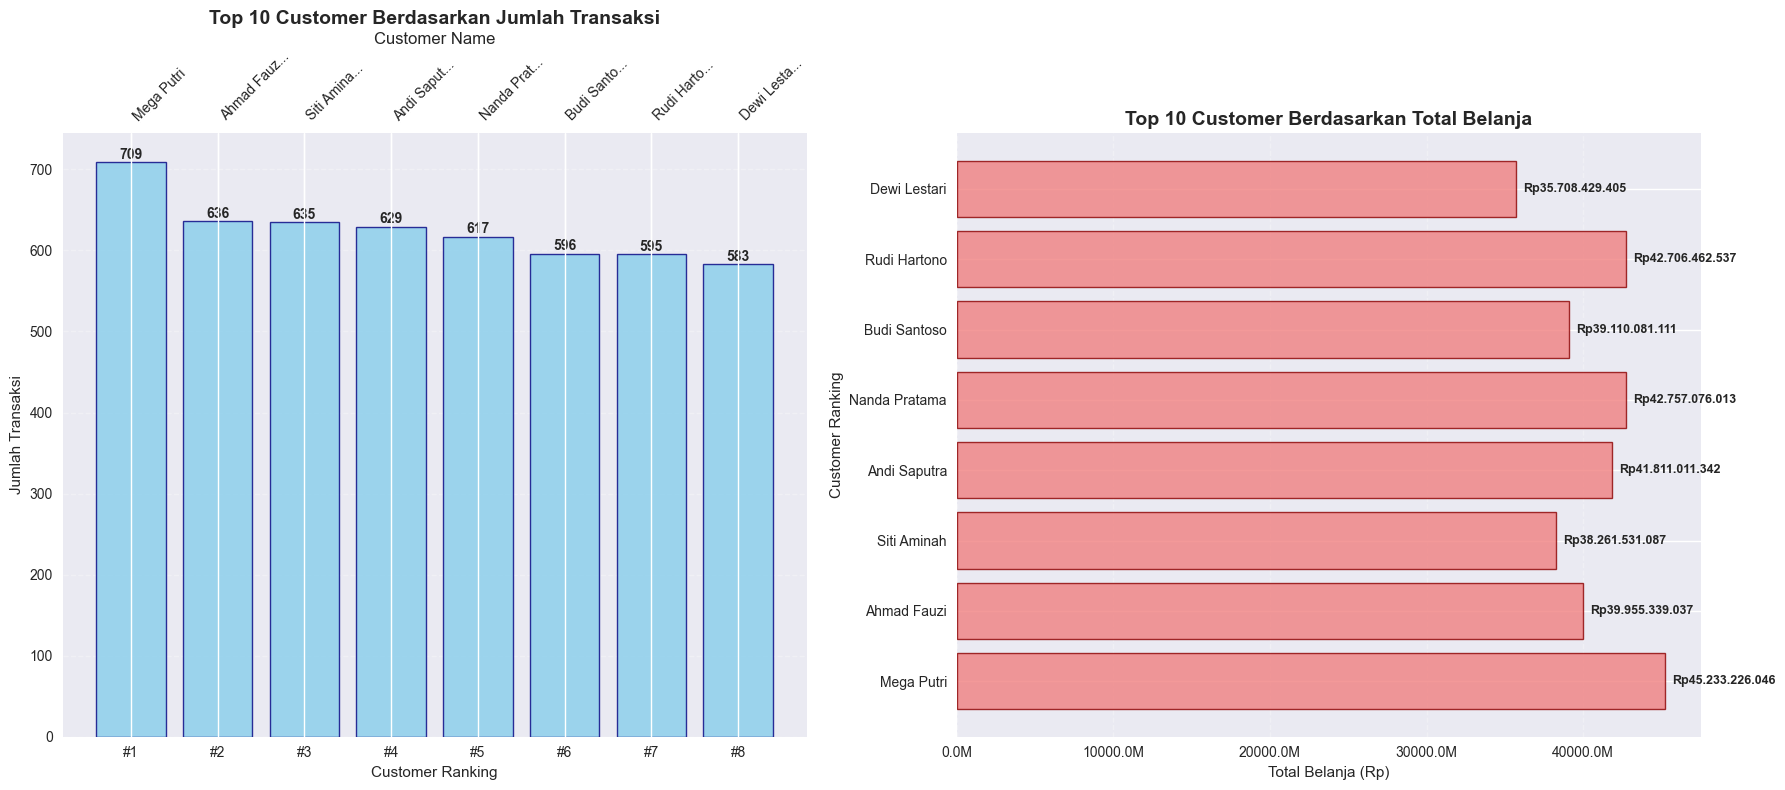

In [337]:
top_6mos = (
    df.groupby('customer_name')
    .agg(total_transaksi=('transaction_id','nunique'),
         total_belanja=('total_amount','sum'))
    .sort_values('total_transaksi', ascending=False)
    .head(10)
)

# Buat copy untuk display (dengan format rupiah)
top_6mos_display = top_6mos.copy()
top_6mos_display['total_belanja'] = top_6mos_display['total_belanja'].apply(format_rupiah)

# Display tabel
print("=== TOP 10 CUSTOMER PALING AKTIF ===")
display(top_6mos_display)

# Visualisasi dengan subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Subplot 1: Bar plot jumlah transaksi
bars1 = ax1.bar(range(len(top_6mos)), top_6mos['total_transaksi'], 
                color='skyblue', alpha=0.8, edgecolor='navy', linewidth=1)
ax1.set_xlabel('Customer Ranking')
ax1.set_ylabel('Jumlah Transaksi')
ax1.set_title('Top 10 Customer Berdasarkan Jumlah Transaksi', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(top_6mos)))
ax1.set_xticklabels([f'#{i+1}' for i in range(len(top_6mos))])

# Tambahkan nilai di atas setiap bar
for i, (bar, count) in enumerate(zip(bars1, top_6mos['total_transaksi'])):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Tambahkan nama customer sebagai label (dirotasi)
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(ax1.get_xlim())
ax1_twin.set_xticks(range(len(top_6mos)))
ax1_twin.set_xticklabels([name[:10] + '...' if len(name) > 10 else name 
                         for name in top_6mos.index], rotation=45, ha='left')
ax1_twin.set_xlabel('Customer Name', fontsize=12)

# Grid untuk readability
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Subplot 2: Bar plot total belanja
bars2 = ax2.barh(range(len(top_6mos)), top_6mos['total_belanja'], 
                 color='lightcoral', alpha=0.8, edgecolor='darkred', linewidth=1)
ax2.set_xlabel('Total Belanja (Rp)')
ax2.set_ylabel('Customer Ranking')
ax2.set_title('Top 10 Customer Berdasarkan Total Belanja', fontsize=14, fontweight='bold')
ax2.set_yticks(range(len(top_6mos)))
ax2.set_yticklabels([name[:15] + '...' if len(name) > 15 else name 
                    for name in top_6mos.index], fontsize=10)

# Format axis untuk jutaan
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000000:.1f}M'))

# Tambahkan nilai di ujung setiap bar
for i, (bar, amount) in enumerate(zip(bars2, top_6mos['total_belanja'])):
    ax2.text(bar.get_width() + max(top_6mos['total_belanja'])*0.01, 
             bar.get_y() + bar.get_height()/2, 
             format_rupiah(amount), va='center', fontweight='bold', fontsize=9)

# Grid untuk readability
ax2.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Nomer 3
“Kira-kira kota mana aja yang paling rame transaksi-nya dan yang paling gede omset-nya?”

Answer: Kota besar seperti Jakarta, Medan, dan Denpasar paling aktif dan berkontribusi besar terhadap revenue.

,jumlah_transaksi,total_omset
customer_city,,
Jakarta,743,Rp49.187.249.737
Medan,691,Rp50.942.507.578
Denpasar,680,Rp39.070.794.641
Yogyakarta,675,Rp52.061.947.158
Bandung,663,Rp38.332.143.613
Surabaya,661,Rp42.209.561.643
Makassar,637,Rp36.285.156.516
Unknown,250,Rp17.453.795.693


C:\Users\AUDIT-PC\AppData\Local\Temp\ipykernel_44636\3854844681.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


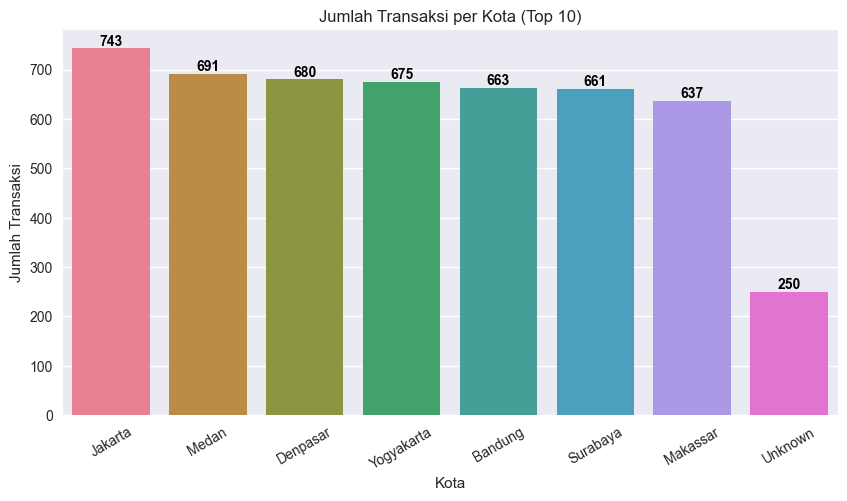

In [338]:
city_stats = (
    df.groupby('customer_city')
    .agg(jumlah_transaksi=('transaction_id','nunique'),
     total_omset=('total_amount','sum')).sort_values('jumlah_transaksi', ascending=False)
)
city_stats['total_omset'] = city_stats['total_omset'].apply(format_rupiah)
display(city_stats.head(10))

# Bar chart jumlah transaksi per kota
plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=city_stats.head(10).reset_index(),
    x='customer_city', y='jumlah_transaksi', palette='husl'
)
plt.title('Jumlah Transaksi per Kota (Top 10)')
plt.xlabel('Kota')
plt.ylabel('Jumlah Transaksi')
plt.xticks(rotation=30)

for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom',
        fontsize=10, fontweight='bold', color='black'
    )

plt.show()

# Nomer 4

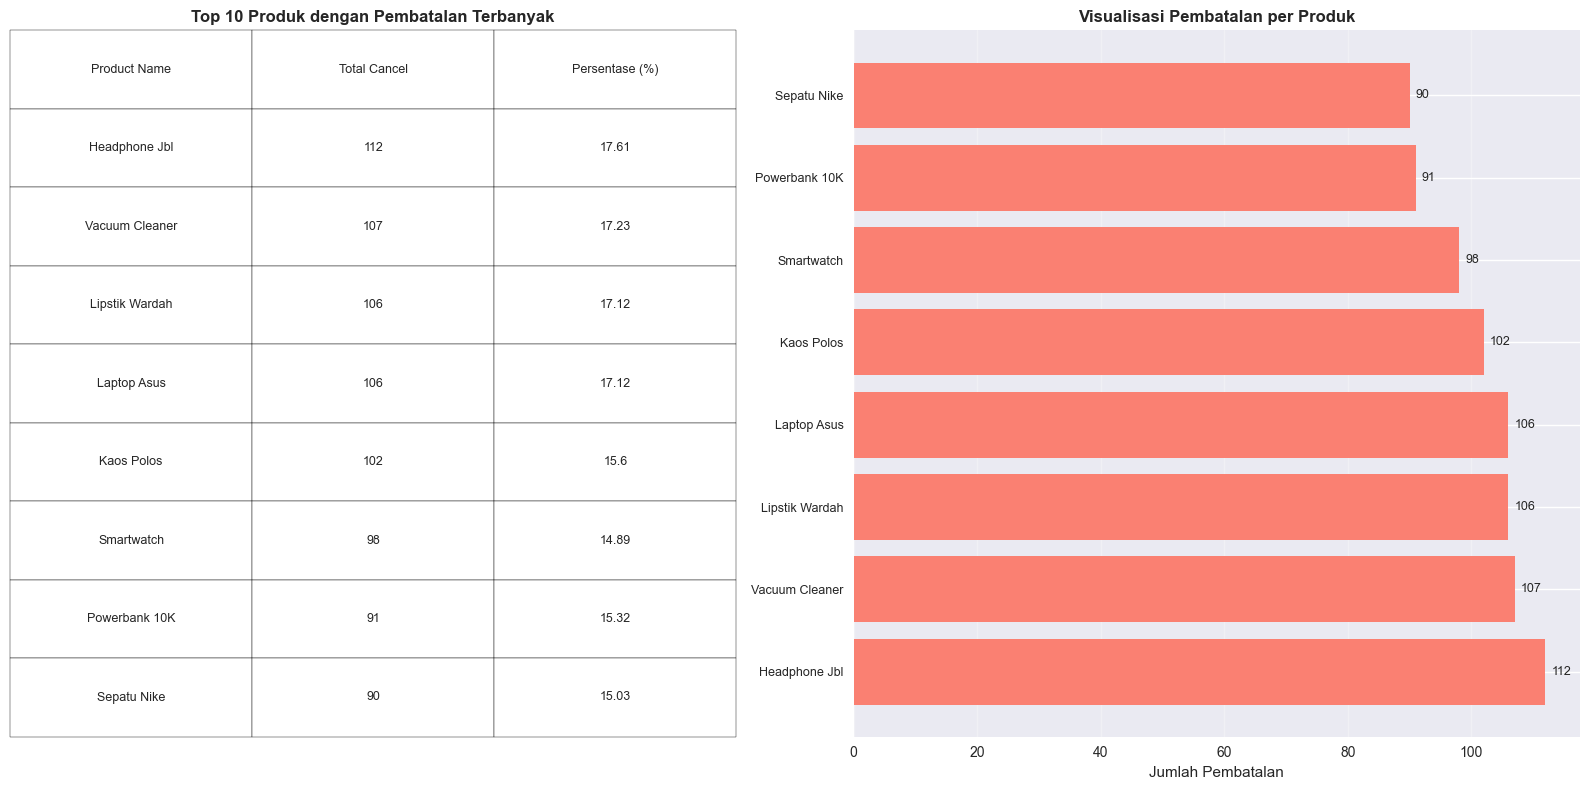

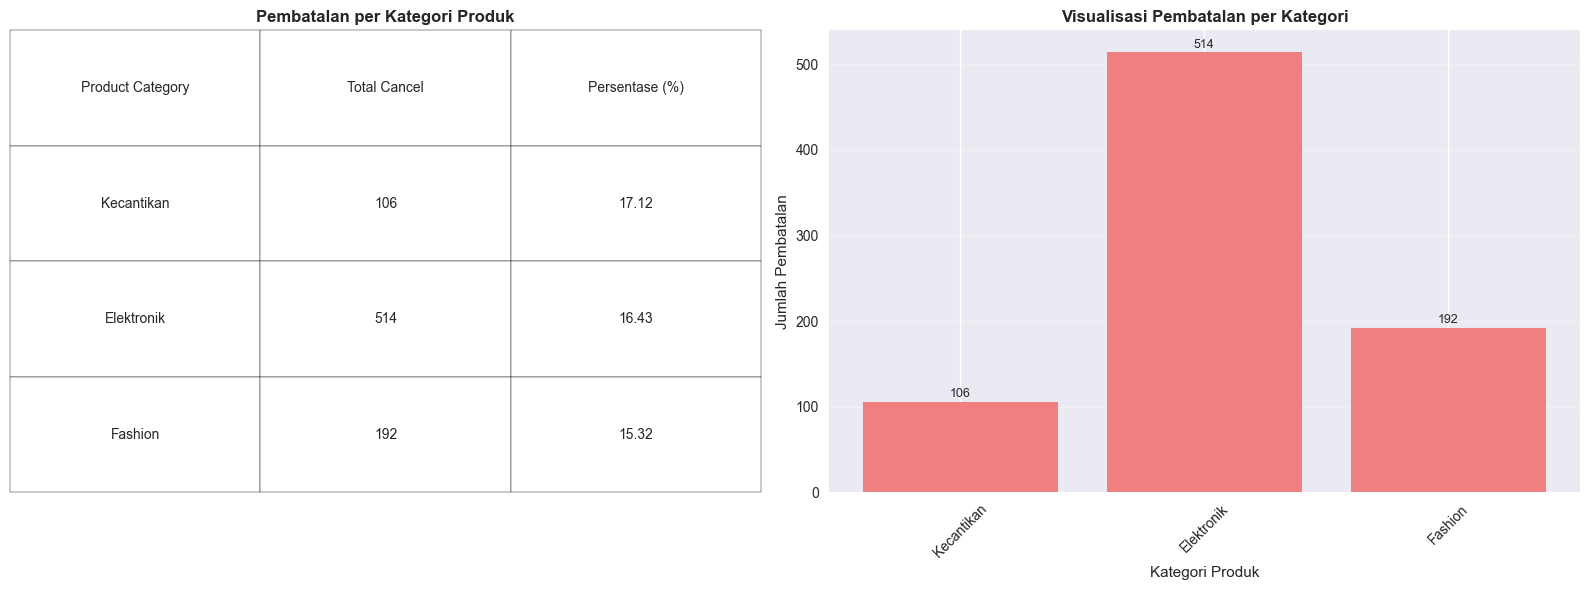

In [339]:
df_cancel = df[df['delivery_status'] == 'Canceled']

# Tabel 1: Analisis pembatalan per produk
total_per_produk = df['product_name'].value_counts()
cancel_per_produk = df_cancel['product_name'].value_counts()

produk_analysis = cancel_per_produk.to_frame('total_cancel')
produk_analysis['product_name'] = produk_analysis.index
produk_analysis['persentase_cancel'] = (cancel_per_produk / total_per_produk * 100).round(2)
produk_analysis = produk_analysis.sort_values('total_cancel', ascending=False)
produk_analysis = produk_analysis[['product_name', 'total_cancel', 'persentase_cancel']].reset_index(drop=True)

# Display tabel dan chart side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Tabel di kiri
ax1.axis('tight')
ax1.axis('off')
table_data = produk_analysis.head(10).values
table = ax1.table(cellText=table_data, 
                 colLabels=['Product Name', 'Total Cancel', 'Persentase (%)'],
                 cellLoc='center', loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)
ax1.set_title('Top 10 Produk dengan Pembatalan Terbanyak', fontsize=12, fontweight='bold')

# Bar chart di kanan
top10_produk = produk_analysis.head(10)
ax2.barh(range(len(top10_produk)), top10_produk['total_cancel'], color='salmon')
ax2.set_yticks(range(len(top10_produk)))
ax2.set_yticklabels([name[:15] + '...' if len(name) > 15 else name for name in top10_produk['product_name']], fontsize=9)
ax2.set_xlabel('Jumlah Pembatalan')
ax2.set_title('Visualisasi Pembatalan per Produk', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Tambahkan nilai di ujung bar
for i, v in enumerate(top10_produk['total_cancel']):
    ax2.text(v + 1, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Tabel 2: Analisis pembatalan per kategori
total_per_kategori = df['product_category'].value_counts()
cancel_per_kategori = df_cancel['product_category'].value_counts()

kategori_analysis = pd.DataFrame({
    'product_category': cancel_per_kategori.index,
    'total_cancel': cancel_per_kategori.values,
    'persentase_cancel': (cancel_per_kategori / total_per_kategori[cancel_per_kategori.index] * 100).round(2)
}).sort_values('persentase_cancel', ascending=False)

kategori_analysis = kategori_analysis.reset_index(drop=True)

# Display tabel dan chart side by side untuk kategori
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Tabel di kiri
ax1.axis('tight')
ax1.axis('off')
table_data = kategori_analysis.values
table = ax1.table(cellText=table_data, 
                 colLabels=['Product Category', 'Total Cancel', 'Persentase (%)'],
                 cellLoc='center', loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.8)
ax1.set_title('Pembatalan per Kategori Produk', fontsize=12, fontweight='bold')

# Bar chart di kanan
ax2.bar(kategori_analysis['product_category'], kategori_analysis['total_cancel'], color='lightcoral')
ax2.set_xlabel('Kategori Produk')
ax2.set_ylabel('Jumlah Pembatalan')
ax2.set_title('Visualisasi Pembatalan per Kategori', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for i, v in enumerate(kategori_analysis['total_cancel']):
    ax2.text(i, v + 2, str(v), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Nomer 5

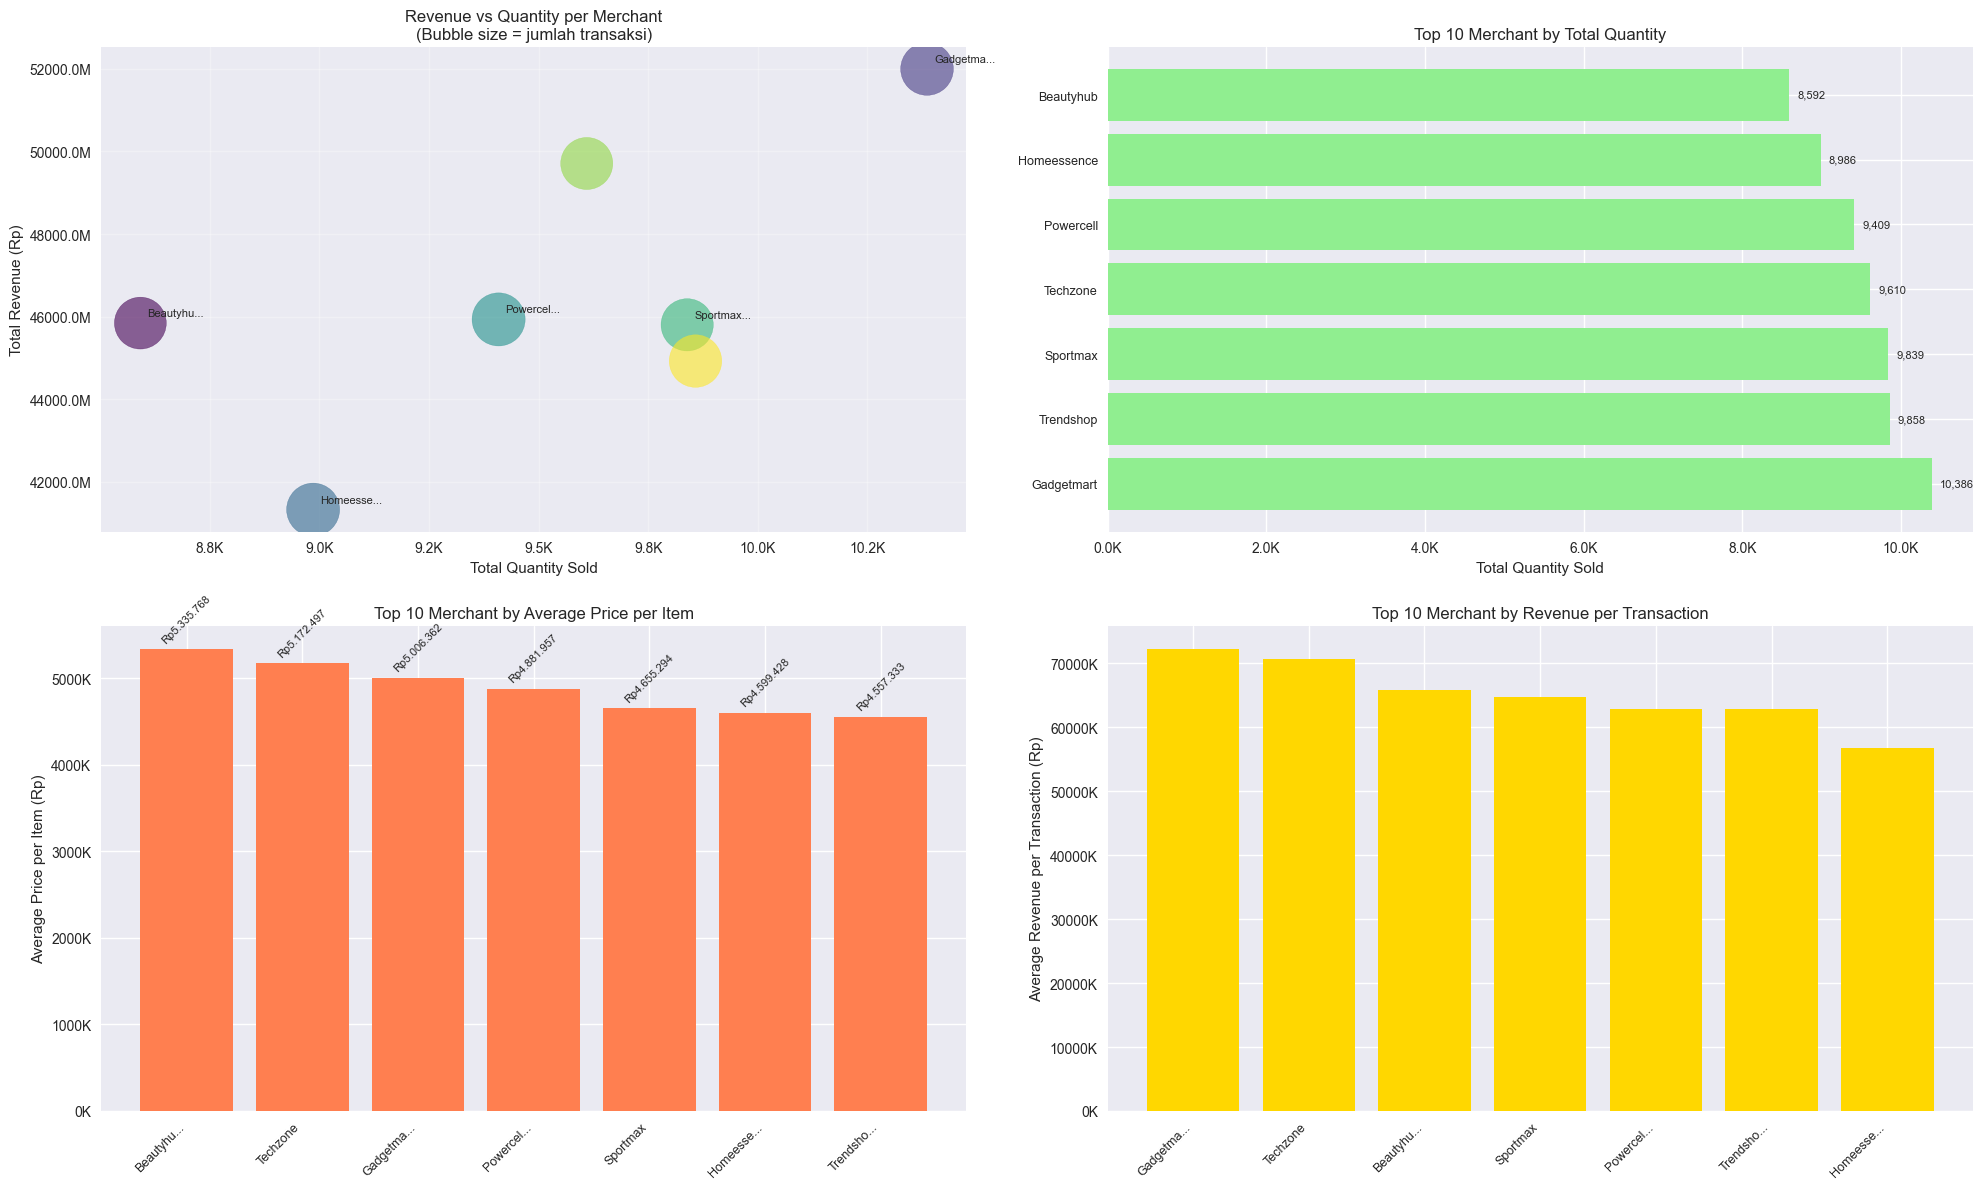


=== COMPREHENSIVE MERCHANT ANALYSIS ===


,merchant_name,total_revenue_formatted,total_quantity,total_transactions,avg_revenue_per_transaction_formatted,avg_price_per_item_formatted
0,Beautyhub,Rp45.844.920.198,8592,697,Rp65.774.634,Rp5.335.768
1,Gadgetmart,Rp51.996.080.774,10386,720,Rp72.216.778,Rp5.006.362
2,Homeessence,Rp41.330.468.479,8986,729,Rp56.694.744,Rp4.599.428
3,Powercell,Rp45.934.342.491,9409,730,Rp62.923.756,Rp4.881.957
4,Sportmax,Rp45.803.447.191,9839,707,Rp64.785.639,Rp4.655.294
5,Techzone,Rp49.707.702.653,9610,703,Rp70.707.969,Rp5.172.497
6,Trendshop,Rp44.926.194.794,9858,714,Rp62.921.841,Rp4.557.333



=== KEY INSIGHTS ===
✓ Total merchants: 7
✓ Total revenue semua merchant: Rp325.543.156.583
✓ Total quantity terjual: 66,680 items
✓ Total transaksi: 5,000

=== TOP PERFORMERS ===
📊 Highest Revenue: Gadgetmart (Rp51.996.080.774)
📦 Highest Quantity: Gadgetmart (10,386 items)
💰 Most Efficient: Gadgetmart (Rp72.216.778 per transaksi)

=== MERCHANT SEGMENTS ===
🏪 Volume Players (High Qty, Low Price): 1 merchants
💎 Premium Players (High Price): 1 merchants
⚡ Efficient Players (High Revenue/Transaction): 2 merchants


In [340]:
# 1. Analisis Revenue (yang sudah ada)
merchant_revenue = (
    df.dropna(subset=['merchant_name', 'total_amount'])
    .groupby('merchant_name')['total_amount']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# 2. TAMBAHAN: Analisis Quantity
merchant_quantity = (
    df.dropna(subset=['merchant_name', 'quantity'])
    .groupby('merchant_name')['quantity']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# 3. Analisis Jumlah Transaksi
merchant_transactions = (
    df.dropna(subset=['merchant_name'])
    .groupby('merchant_name')['transaction_id']
    .count()
    .sort_values(ascending=False)
    .reset_index()
)

# 4. Gabungkan semua metrics
merchant_complete = pd.merge(
    merchant_revenue.rename(columns={'total_amount': 'total_revenue'}),
    merchant_quantity.rename(columns={'quantity': 'total_quantity'}),
    on='merchant_name', how='outer'
).fillna(0)

merchant_complete = pd.merge(
    merchant_complete,
    merchant_transactions.rename(columns={'transaction_id': 'total_transactions'}),
    on='merchant_name', how='outer'
).fillna(0)

# 5. Hitung metrics tambahan
merchant_complete['avg_revenue_per_transaction'] = merchant_complete['total_revenue'] / merchant_complete['total_transactions']
merchant_complete['avg_quantity_per_transaction'] = merchant_complete['total_quantity'] / merchant_complete['total_transactions']
merchant_complete['avg_price_per_item'] = merchant_complete['total_revenue'] / merchant_complete['total_quantity']

# Format untuk display
merchant_display = merchant_complete.head(10).copy()
merchant_display['total_revenue_formatted'] = merchant_display['total_revenue'].apply(format_rupiah)
merchant_display['avg_revenue_per_transaction_formatted'] = merchant_display['avg_revenue_per_transaction'].apply(format_rupiah)
merchant_display['avg_price_per_item_formatted'] = merchant_display['avg_price_per_item'].apply(format_rupiah)

# 6. Multiple visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Subplot 1: Revenue vs Quantity Scatter
top_merchants = merchant_complete.head(15)
scatter = ax1.scatter(top_merchants['total_quantity'], top_merchants['total_revenue'], 
                     s=top_merchants['total_transactions']*2, alpha=0.6, 
                     c=range(len(top_merchants)), cmap='viridis')
ax1.set_xlabel('Total Quantity Sold')
ax1.set_ylabel('Total Revenue (Rp)')
ax1.set_title('Revenue vs Quantity per Merchant\n(Bubble size = jumlah transaksi)')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000000:.1f}M'))
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.1f}K'))
ax1.grid(alpha=0.3)

# Tambahkan label untuk top 5
for i, row in top_merchants.head(5).iterrows():
    ax1.annotate(row['merchant_name'][:8] + '...', 
                (row['total_quantity'], row['total_revenue']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# Subplot 2: Top 10 by Quantity
top_qty = merchant_complete.nlargest(10, 'total_quantity')
bars2 = ax2.barh(range(len(top_qty)), top_qty['total_quantity'], color='lightgreen')
ax2.set_yticks(range(len(top_qty)))
ax2.set_yticklabels([name[:12] + '...' if len(name) > 12 else name for name in top_qty['merchant_name']], fontsize=9)
ax2.set_xlabel('Total Quantity Sold')
ax2.set_title('Top 10 Merchant by Total Quantity')
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.1f}K'))

# Tambahkan nilai di ujung bar
for i, v in enumerate(top_qty['total_quantity']):
    ax2.text(v + max(top_qty['total_quantity'])*0.01, i, f'{v:,.0f}', va='center', fontsize=8)

# Subplot 3: Average Price per Item
top_price = merchant_complete.nlargest(10, 'avg_price_per_item')
bars3 = ax3.bar(range(len(top_price)), top_price['avg_price_per_item'], color='coral')
ax3.set_xticks(range(len(top_price)))
ax3.set_xticklabels([name[:8] + '...' if len(name) > 8 else name for name in top_price['merchant_name']], 
                   rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('Average Price per Item (Rp)')
ax3.set_title('Top 10 Merchant by Average Price per Item')
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

# Tambahkan nilai di atas bar
for i, v in enumerate(top_price['avg_price_per_item']):
    ax3.text(i, v + max(top_price['avg_price_per_item'])*0.01, 
             format_rupiah(v), ha='center', va='bottom', fontsize=8, rotation=45)

# Subplot 4: Efficiency Analysis (Revenue per Transaction)
top_efficiency = merchant_complete.nlargest(10, 'avg_revenue_per_transaction')
bars4 = ax4.bar(range(len(top_efficiency)), top_efficiency['avg_revenue_per_transaction'], color='gold')
ax4.set_xticks(range(len(top_efficiency)))
ax4.set_xticklabels([name[:8] + '...' if len(name) > 8 else name for name in top_efficiency['merchant_name']], 
                   rotation=45, ha='right', fontsize=9)
ax4.set_ylabel('Average Revenue per Transaction (Rp)')
ax4.set_title('Top 10 Merchant by Revenue per Transaction')
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

plt.tight_layout()
plt.show()

# 7. Summary Table
print(f"\n=== COMPREHENSIVE MERCHANT ANALYSIS ===")
display(merchant_display[['merchant_name', 'total_revenue_formatted', 'total_quantity', 
                         'total_transactions', 'avg_revenue_per_transaction_formatted', 
                         'avg_price_per_item_formatted']].head(10))

# 8. Key Insights
print(f"\n=== KEY INSIGHTS ===")
print(f"✓ Total merchants: {len(merchant_complete)}")
print(f"✓ Total revenue semua merchant: {format_rupiah(merchant_complete['total_revenue'].sum())}")
print(f"✓ Total quantity terjual: {merchant_complete['total_quantity'].sum():,.0f} items")
print(f"✓ Total transaksi: {merchant_complete['total_transactions'].sum():,.0f}")

# Top performers by different metrics
top_revenue_merchant = merchant_complete.loc[merchant_complete['total_revenue'].idxmax()]
top_quantity_merchant = merchant_complete.loc[merchant_complete['total_quantity'].idxmax()]
top_efficiency_merchant = merchant_complete.loc[merchant_complete['avg_revenue_per_transaction'].idxmax()]

print(f"\n=== TOP PERFORMERS ===")
print(f"📊 Highest Revenue: {top_revenue_merchant['merchant_name']} ({format_rupiah(top_revenue_merchant['total_revenue'])})")
print(f"📦 Highest Quantity: {top_quantity_merchant['merchant_name']} ({top_quantity_merchant['total_quantity']:,.0f} items)")
print(f"💰 Most Efficient: {top_efficiency_merchant['merchant_name']} ({format_rupiah(top_efficiency_merchant['avg_revenue_per_transaction'])} per transaksi)")

# Segment merchants
print(f"\n=== MERCHANT SEGMENTS ===")
high_vol_low_price = merchant_complete[(merchant_complete['total_quantity'] > merchant_complete['total_quantity'].quantile(0.75)) & 
                                      (merchant_complete['avg_price_per_item'] < merchant_complete['avg_price_per_item'].quantile(0.5))]
print(f"🏪 Volume Players (High Qty, Low Price): {len(high_vol_low_price)} merchants")

premium_players = merchant_complete[merchant_complete['avg_price_per_item'] > merchant_complete['avg_price_per_item'].quantile(0.9)]
print(f"💎 Premium Players (High Price): {len(premium_players)} merchants")

efficient_players = merchant_complete[merchant_complete['avg_revenue_per_transaction'] > merchant_complete['avg_revenue_per_transaction'].quantile(0.8)]
print(f"⚡ Efficient Players (High Revenue/Transaction): {len(efficient_players)} merchants")

# Nomer 6

Q1: Rp2.612.667
Q3: Rp7.463.527
IQR: Rp4.850.860
Batas bawah outlier: Rp-4.663.623
Batas atas outlier: Rp14.739.818

Total produk outlier: 48 (1.0%)
Total produk normal: 4,952 (99.0%)


C:\Users\AUDIT-PC\AppData\Local\Temp\ipykernel_44636\4116976823.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot([df_clean[df_clean['product_category'] == cat]['unit_price'].values


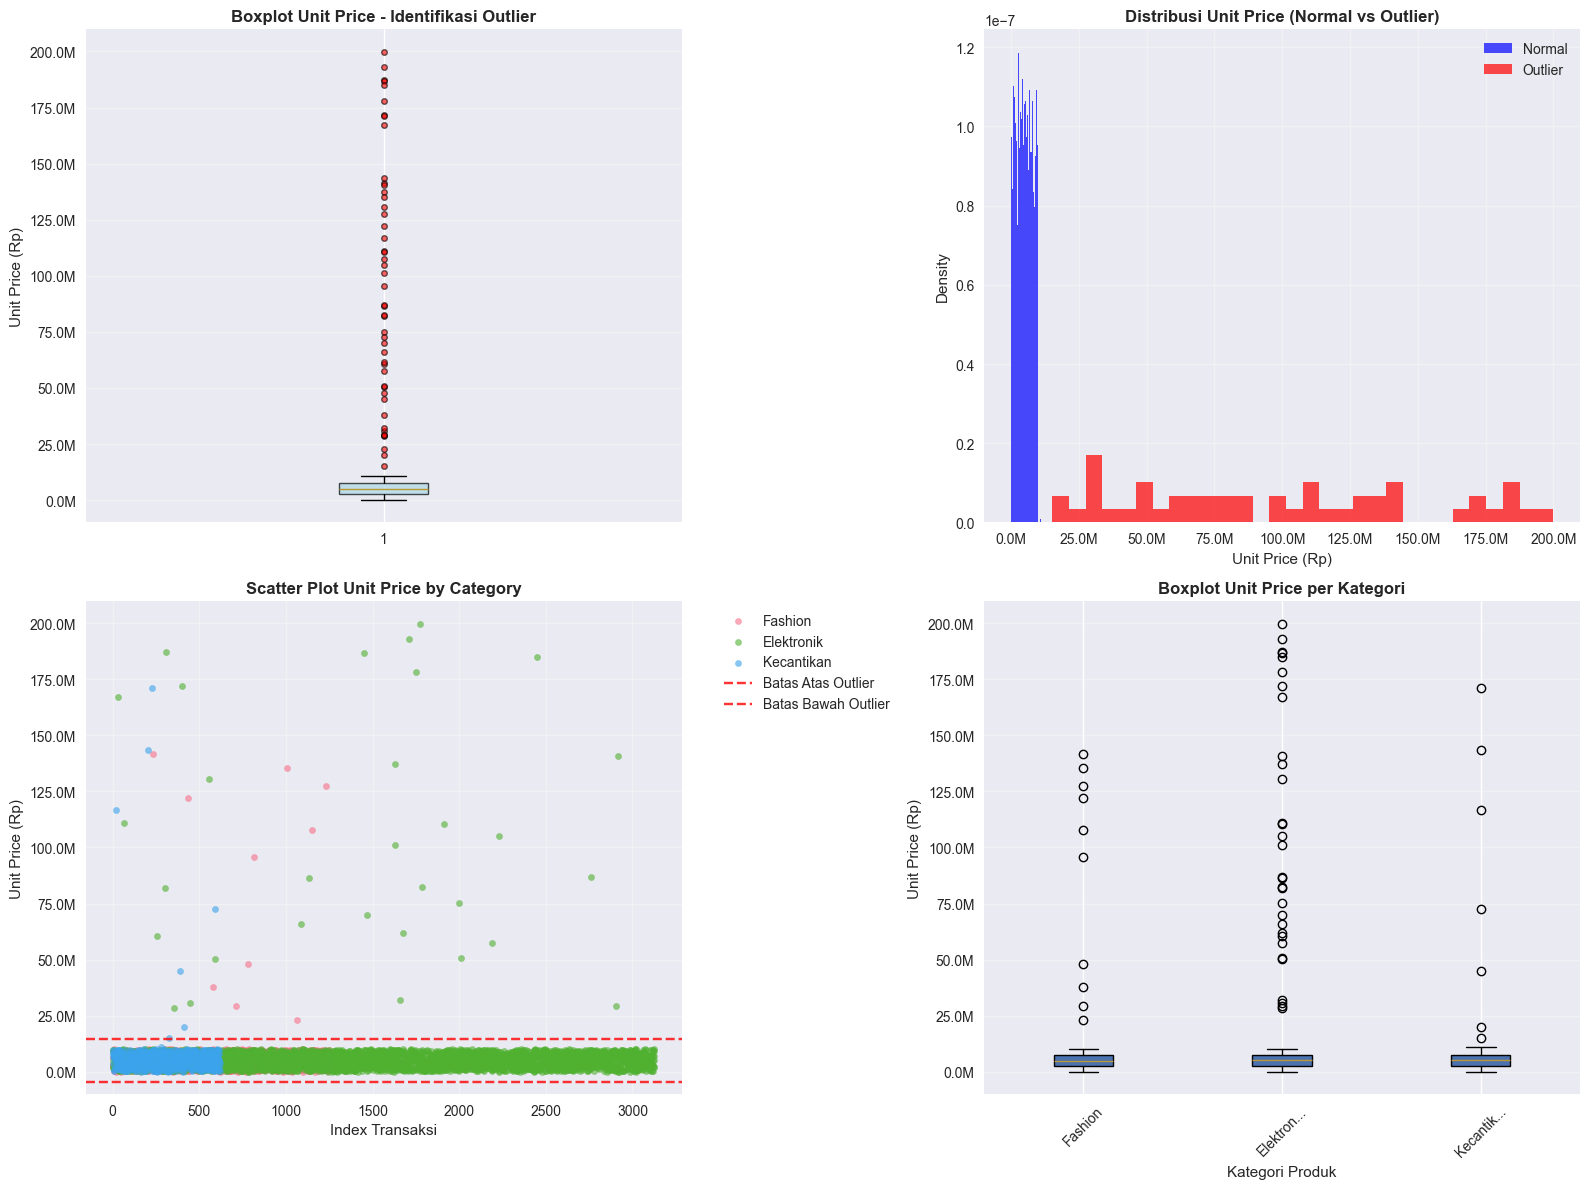


=== TOP 10 PRODUK OUTLIER TERMAHAL ===


,product_name,product_category,unit_price_formatted,merchant_name
2854,Laptop Asus,Elektronik,Rp199.835.860,Powercell
2759,Vacuum Cleaner,Elektronik,Rp192.940.200,Powercell
511,Headphone Jbl,Elektronik,Rp187.253.040,Sportmax
2338,Vacuum Cleaner,Elektronik,Rp186.685.520,Sportmax
3913,Laptop Asus,Elektronik,Rp185.101.060,Sportmax
2822,Smartwatch,Elektronik,Rp178.062.860,Trendshop
657,Vacuum Cleaner,Elektronik,Rp171.885.820,Techzone
1851,Lipstik Wardah,Kecantikan,Rp171.143.000,Beautyhub
47,Vacuum Cleaner,Elektronik,Rp167.129.220,Sportmax
1671,Lipstik Wardah,Kecantikan,Rp143.562.920,Sportmax



=== TOP 10 PRODUK OUTLIER TERMURAH ===


,product_name,product_category,unit_price_formatted,merchant_name
3086,Lipstik Wardah,Kecantikan,Rp45.057.760,Powercell
2259,Kaos Polos,Fashion,Rp37.914.660,Gadgetmart
2675,Laptop Asus,Elektronik,Rp32.034.520,Powercell
728,Smartwatch,Elektronik,Rp30.800.720,Homeessence
4645,Vacuum Cleaner,Elektronik,Rp29.106.260,Beautyhub
2816,Kaos Polos,Fashion,Rp29.091.360,Trendshop
585,Headphone Jbl,Elektronik,Rp28.567.380,Beautyhub
4280,Sepatu Nike,Fashion,Rp22.881.920,Sportmax
3247,Lipstik Wardah,Kecantikan,Rp20.162.020,Trendshop
2616,Lipstik Wardah,Kecantikan,Rp15.258.340,Homeessence



=== OUTLIER PER KATEGORI ===
Elektronik:
  - Jumlah outlier: 31
  - Harga rata-rata: Rp105.002.259
  - Harga tertinggi: Rp199.835.860
  - Harga terendah: Rp28.567.380
Fashion:
  - Jumlah outlier: 10
  - Harga rata-rata: Rp86.724.966
  - Harga tertinggi: Rp141.574.440
  - Harga terendah: Rp22.881.920
Kecantikan:
  - Jumlah outlier: 7
  - Harga rata-rata: Rp83.478.643
  - Harga tertinggi: Rp171.143.000
  - Harga terendah: Rp15.258.340


In [341]:
# 1. Hitung outlier menggunakan IQR method
Q1 = df['unit_price'].quantile(0.25)
Q3 = df['unit_price'].quantile(0.75)
IQR = Q3 - Q1

batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

print(f"Q1: {format_rupiah(Q1)}")
print(f"Q3: {format_rupiah(Q3)}")
print(f"IQR: {format_rupiah(IQR)}")
print(f"Batas bawah outlier: {format_rupiah(batas_bawah)}")
print(f"Batas atas outlier: {format_rupiah(batas_atas)}")

# 2. Identifikasi outlier
outlier_mask = (df['unit_price'] < batas_bawah) | (df['unit_price'] > batas_atas)
produk_outlier = df[outlier_mask].copy()
produk_normal = df[~outlier_mask].copy()

print(f"\nTotal produk outlier: {len(produk_outlier):,} ({len(produk_outlier)/len(df)*100:.1f}%)")
print(f"Total produk normal: {len(produk_normal):,} ({len(produk_normal)/len(df)*100:.1f}%)")

# 3. Multiple visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Boxplot - TERBAIK untuk outlier
ax1.boxplot(df['unit_price'], vert=True, patch_artist=True, 
           boxprops=dict(facecolor='lightblue', alpha=0.7),
           flierprops=dict(marker='o', markerfacecolor='red', markersize=4, alpha=0.6))
ax1.set_title('Boxplot Unit Price - Identifikasi Outlier', fontweight='bold')
ax1.set_ylabel('Unit Price (Rp)')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000000:.1f}M'))
ax1.grid(axis='y', alpha=0.3)

# Subplot 2: Histogram dengan outlier highlighted
ax2.hist(produk_normal['unit_price'], bins=50, alpha=0.7, color='blue', label='Normal', density=True)
ax2.hist(produk_outlier['unit_price'], bins=30, alpha=0.7, color='red', label='Outlier', density=True)
ax2.set_title('Distribusi Unit Price (Normal vs Outlier)', fontweight='bold')
ax2.set_xlabel('Unit Price (Rp)')
ax2.set_ylabel('Density')
ax2.legend()
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000000:.1f}M'))
ax2.grid(alpha=0.3)

# Subplot 3: Scatter plot by category
categories = df['product_category'].unique()
colors = sns.color_palette("husl", len(categories))
for i, cat in enumerate(categories):
    if cat != 'Unknown':
        cat_data = df[df['product_category'] == cat]
        ax3.scatter(range(len(cat_data)), cat_data['unit_price'], 
                   c=[colors[i]], label=cat, alpha=0.6, s=20)

ax3.axhline(y=batas_atas, color='red', linestyle='--', alpha=0.8, label='Batas Atas Outlier')
ax3.axhline(y=batas_bawah, color='red', linestyle='--', alpha=0.8, label='Batas Bawah Outlier')
ax3.set_title('Scatter Plot Unit Price by Category', fontweight='bold')
ax3.set_xlabel('Index Transaksi')
ax3.set_ylabel('Unit Price (Rp)')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000000:.1f}M'))
ax3.grid(alpha=0.3)

# Subplot 4: Boxplot per kategori
df_clean = df[df['product_category'] != 'Unknown']
ax4.boxplot([df_clean[df_clean['product_category'] == cat]['unit_price'].values 
             for cat in df_clean['product_category'].unique()],
            labels=[cat[:8] + '...' if len(cat) > 8 else cat 
                   for cat in df_clean['product_category'].unique()],
            patch_artist=True)
ax4.set_title('Boxplot Unit Price per Kategori', fontweight='bold')
ax4.set_xlabel('Kategori Produk')
ax4.set_ylabel('Unit Price (Rp)')
ax4.tick_params(axis='x', rotation=45)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000000:.1f}M'))
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Detail produk outlier
produk_outlier_detail = produk_outlier[['product_category', 'product_name', 'unit_price', 'merchant_name']].copy()
produk_outlier_detail = produk_outlier_detail.sort_values('unit_price', ascending=False)

print(f"\n=== TOP 10 PRODUK OUTLIER TERMAHAL ===")
top_expensive = produk_outlier_detail.head(10).copy()
top_expensive['unit_price_formatted'] = top_expensive['unit_price'].apply(format_rupiah)
display(top_expensive[['product_name', 'product_category', 'unit_price_formatted', 'merchant_name']])

print(f"\n=== TOP 10 PRODUK OUTLIER TERMURAH ===")
top_cheap = produk_outlier_detail.tail(10).copy()
top_cheap['unit_price_formatted'] = top_cheap['unit_price'].apply(format_rupiah)
display(top_cheap[['product_name', 'product_category', 'unit_price_formatted', 'merchant_name']])

# 5. Analisis outlier per kategori
print(f"\n=== OUTLIER PER KATEGORI ===")
outlier_by_category = produk_outlier.groupby('product_category').agg({
    'unit_price': ['count', 'mean', 'max', 'min'],
    'transaction_id': 'count'
}).round(0)

outlier_by_category.columns = ['count_outlier', 'avg_price', 'max_price', 'min_price', 'total_transactions']
outlier_by_category = outlier_by_category.sort_values('count_outlier', ascending=False)

for idx, row in outlier_by_category.iterrows():
    if idx != 'Unknown':
        print(f"{idx}:")
        print(f"  - Jumlah outlier: {int(row['count_outlier']):,}")
        print(f"  - Harga rata-rata: {format_rupiah(row['avg_price'])}")
        print(f"  - Harga tertinggi: {format_rupiah(row['max_price'])}")
        print(f"  - Harga terendah: {format_rupiah(row['min_price'])}")

# Nomer 7

In [342]:
payment_count = df.groupby(['customer_city', 'payment_method'])['transaction_id'].count().reset_index()
payment_count

,customer_city,payment_method,transaction_id
0,Bandung,Cod,116
1,Bandung,E-Wallet,208
2,Bandung,Kartu Kredit,209
3,Bandung,Transfer,107
4,Bandung,Unknown,23
5,Denpasar,Cod,110
6,Denpasar,E-Wallet,204
7,Denpasar,Kartu Kredit,223
8,Denpasar,Transfer,107
9,Denpasar,Unknown,36


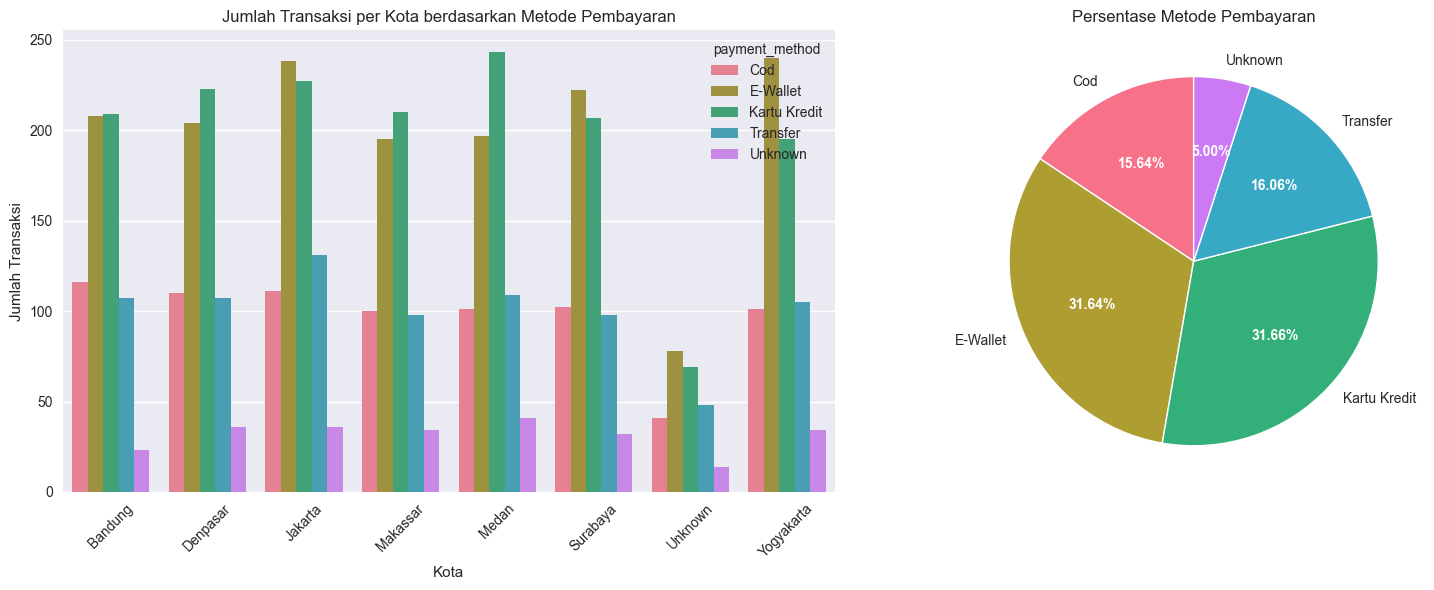


Detail Persentase Metode Pembayaran:
Cod: 15.64%
E-Wallet: 31.64%
Kartu Kredit: 31.66%
Transfer: 16.06%
Unknown: 5.00%


In [343]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot di subplot pertama
sns.barplot(
    data=payment_count, x='customer_city', y='transaction_id', 
    hue='payment_method', palette='husl', ax=ax1)
ax1.set_title('Jumlah Transaksi per Kota berdasarkan Metode Pembayaran')
ax1.set_ylabel('Jumlah Transaksi')
ax1.set_xlabel('Kota')
ax1.tick_params(axis='x', rotation=45)

# Hitung persentase metode pembayaran untuk pie chart
payment_method_total = df.groupby('payment_method')['transaction_id'].count()
payment_method_percentage = (payment_method_total / payment_method_total.sum() * 100)

# Pie chart di subplot kedua
colors = sns.color_palette("husl", len(payment_method_total))
wedges, texts, autotexts = ax2.pie(
    payment_method_total.values, 
    labels=payment_method_total.index,
    autopct='%1.2f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)

# Styling pie chart
ax2.set_title('Persentase Metode Pembayaran')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

# Tampilkan detail persentase
print("\nDetail Persentase Metode Pembayaran:")
for method, pct in payment_method_percentage.items():
    print(f"{method}: {pct:.2f}%")

# Nomer 8

In [344]:
gagal = ['canceled', 'returned', 'Canceled', 'Returned']
jumlah_gagal = df['delivery_status'].isin(gagal).sum()
persen_gagal = (jumlah_gagal / len(df)) * 100

print(f"Jumlah transaksi gagal: {jumlah_gagal}")
print(f"Persentase Transaksi Gagal: {persen_gagal:.2f}%")

Jumlah transaksi gagal: 1601
Persentase Transaksi Gagal: 32.02%


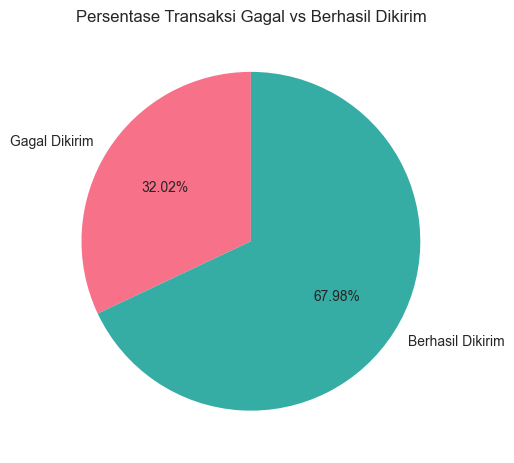

In [345]:
jumlah_berhasil = len(df) - jumlah_gagal
colors = sns.color_palette("husl", 2)

plt.pie([jumlah_gagal, jumlah_berhasil],
    labels=['Gagal Dikirim', 'Berhasil Dikirim'],
    autopct='%.2f%%',
    startangle=90,
    colors=colors
)
plt.title('Persentase Transaksi Gagal vs Berhasil Dikirim')
plt.show()

# Nomer 9

Persentase Kegagalan per Metode Pembayaran:
Transfer: 33.87%
Cod: 32.99%
E-Wallet: 32.17%
Kartu Kredit: 30.95%
Unknown: 28.80%


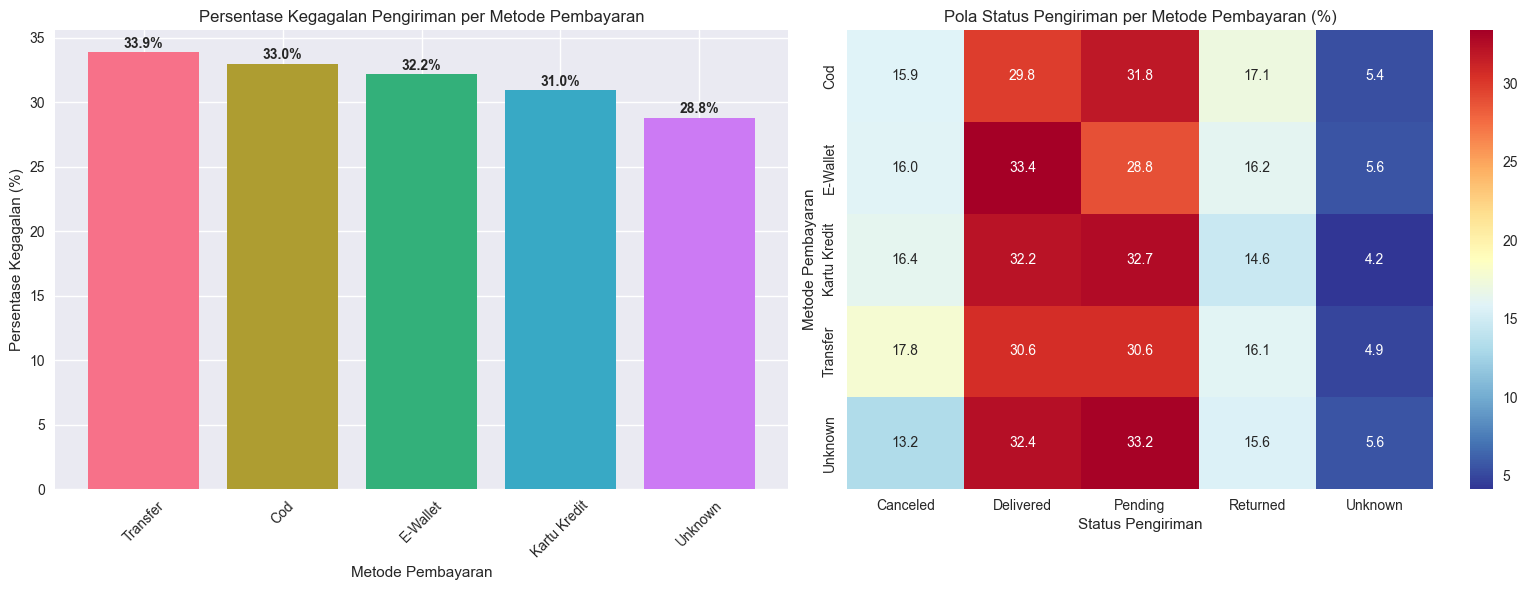


=== ANALISIS POLA ===
✓ Metode pembayaran dengan kegagalan tertinggi: Transfer (33.87%)
✓ Metode pembayaran dengan kegagalan terendah: Unknown (28.80%)
✗ Hipotesis tidak terkonfirmasi: Transfer yang paling sering gagal, bukan COD


In [346]:
df['is_gagal'] = df['delivery_status'].isin(gagal).astype(int)

persentase_gagal_permethod = (df.groupby('payment_method')['is_gagal'].mean() * 100).reset_index()
persentase_gagal_permethod.columns = ['payment_method', 'persentase_gagal']
persentase_gagal_permethod = persentase_gagal_permethod.sort_values('persentase_gagal', ascending=False)

# Tampilkan tabel
print("Persentase Kegagalan per Metode Pembayaran:")
for _, row in persentase_gagal_permethod.iterrows():
    print(f"{row['payment_method']}: {row['persentase_gagal']:.2f}%")

# Buat visualisasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart persentase kegagalan
bars = ax1.bar(persentase_gagal_permethod['payment_method'], 
               persentase_gagal_permethod['persentase_gagal'],
               color=sns.color_palette("husl", len(persentase_gagal_permethod)))
ax1.set_title('Persentase Kegagalan Pengiriman per Metode Pembayaran')
ax1.set_ylabel('Persentase Kegagalan (%)')
ax1.set_xlabel('Metode Pembayaran')
ax1.tick_params(axis='x', rotation=45)

# Tambahkan nilai di atas bar
for bar, pct in zip(bars, persentase_gagal_permethod['persentase_gagal']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

# Heatmap untuk melihat pola detail
crosstab = pd.crosstab(df['payment_method'], df['delivery_status'], normalize='index') * 100
sns.heatmap(crosstab, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=ax2)
ax2.set_title('Pola Status Pengiriman per Metode Pembayaran (%)')
ax2.set_xlabel('Status Pengiriman')
ax2.set_ylabel('Metode Pembayaran')

plt.tight_layout()
plt.show()

# Analisis pola
print("\n=== ANALISIS POLA ===")
max_gagal = persentase_gagal_permethod.iloc[0]
min_gagal = persentase_gagal_permethod.iloc[-1]

print(f"✓ Metode pembayaran dengan kegagalan tertinggi: {max_gagal['payment_method']} ({max_gagal['persentase_gagal']:.2f}%)")
print(f"✓ Metode pembayaran dengan kegagalan terendah: {min_gagal['payment_method']} ({min_gagal['persentase_gagal']:.2f}%)")

if max_gagal['payment_method'] == 'Cod':
    print("✓ Hipotesis terkonfirmasi: COD memang lebih sering gagal dibanding metode lain")
else:
    print(f"✗ Hipotesis tidak terkonfirmasi: {max_gagal['payment_method']} yang paling sering gagal, bukan COD")

> - adanya limit pada total transaksi pada metode pembayaran transfer, dilihat dari pola transaksi yang cenderung besar
> - untuk cod dikarenakan barang tidak sesuai atau ketidaksengajaan dalam proses pembelian

# Nomer 10

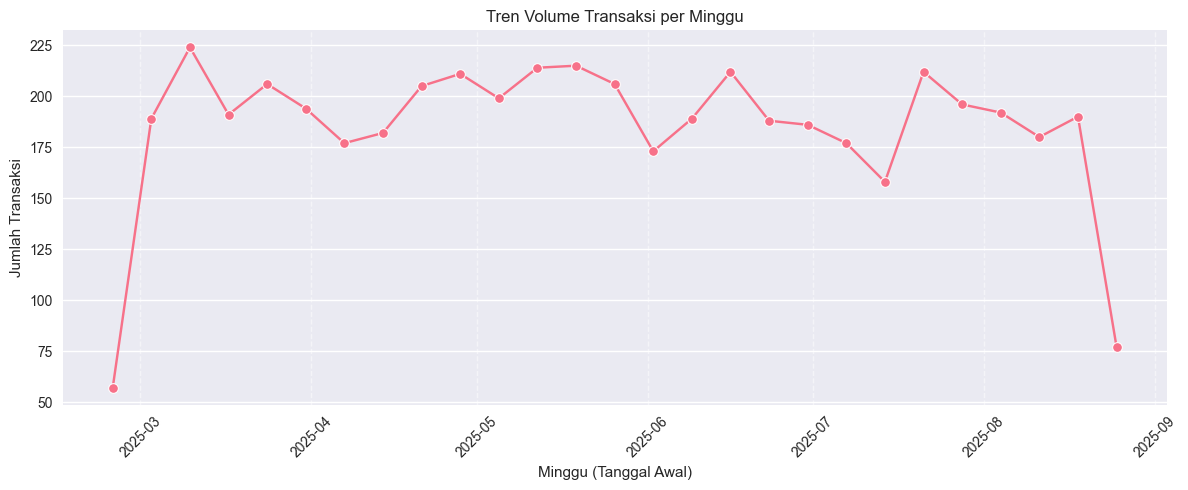

In [347]:
if 'transaction_date' in df.columns:
    df['week'] = df['transaction_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_trend = df.groupby('week').size()
    plt.figure(figsize=(12,5))
    sns.lineplot(x=weekly_trend.index, y=weekly_trend.values, marker='o')
    plt.title('Tren Volume Transaksi per Minggu')
    plt.xlabel('Minggu (Tanggal Awal)')
    plt.ylabel('Jumlah Transaksi')
    plt.xticks(rotation=45)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Nomer 11

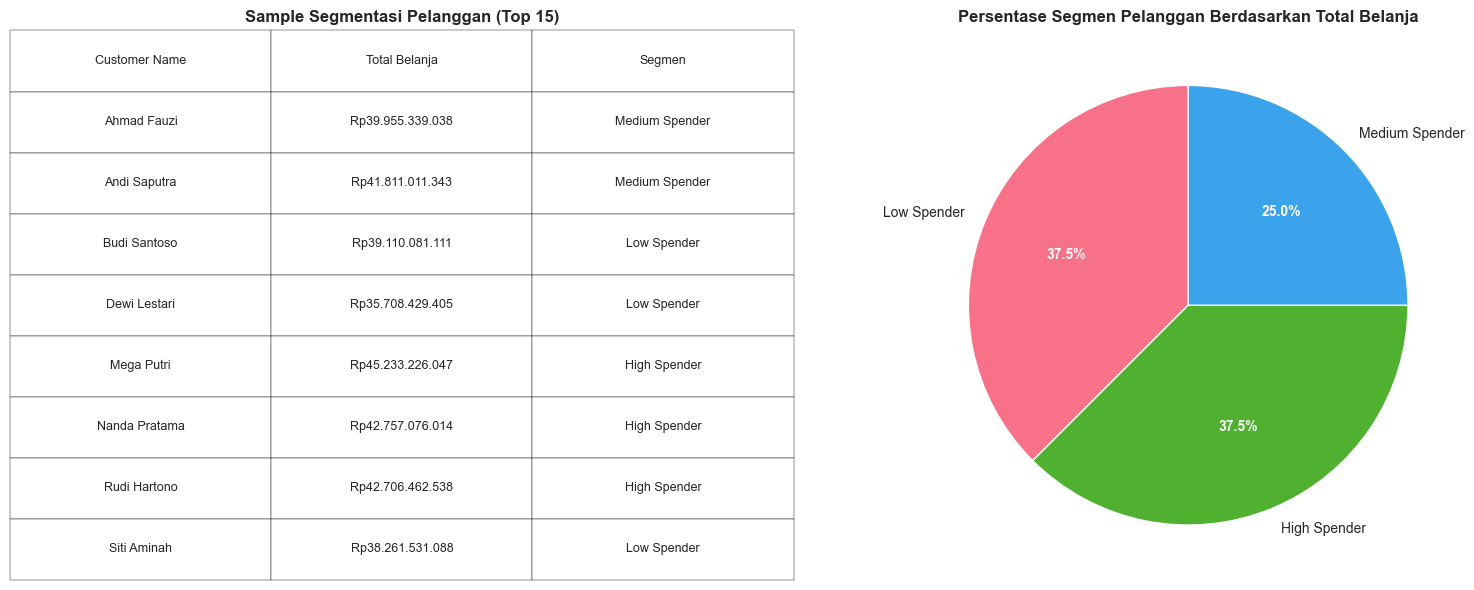


=== RINGKASAN SEGMENTASI ===
Low Spender: 3 pelanggan (37.5%)
High Spender: 3 pelanggan (37.5%)
Medium Spender: 2 pelanggan (25.0%)


In [348]:
if 'customer_name' in df.columns and 'total_amount' in df.columns:
    total_belanja = df.groupby('customer_name')['total_amount'].sum()
    bins = [0, total_belanja.quantile(0.33), total_belanja.quantile(0.67), total_belanja.max()+1]
    labels = ['Low Spender', 'Medium Spender', 'High Spender']
    segmen = pd.cut(total_belanja, bins=bins, labels=labels, include_lowest=True)
    segmentasi = pd.DataFrame({'customer_name': total_belanja.index, 'total_belanja': total_belanja.values, 'segmen': segmen})
    segmentasi['total_belanja_rupiah'] = segmentasi['total_belanja'].apply(lambda x: f"Rp{x:,.0f}".replace(",", "."))
    
    # Buat figure dengan 2 subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Tabel di kiri - tampilkan sample data (top 15)
    ax1.axis('tight')
    ax1.axis('off')
    table_data = segmentasi.head(15)[['customer_name', 'total_belanja_rupiah', 'segmen']].values
    table = ax1.table(cellText=table_data, 
                     colLabels=['Customer Name', 'Total Belanja', 'Segmen'],
                     cellLoc='center', loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.2)
    ax1.set_title('Sample Segmentasi Pelanggan (Top 15)', fontsize=12, fontweight='bold')
    
    # Pie chart di kanan
    segmen_counts = segmentasi['segmen'].value_counts()
    colors = sns.color_palette("husl", 3)
    wedges, texts, autotexts = ax2.pie(
        segmen_counts.values,
        labels=segmen_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )
    ax2.set_title('Persentase Segmen Pelanggan Berdasarkan Total Belanja', fontsize=12, fontweight='bold')
    
    # Styling pie chart
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    plt.tight_layout()
    plt.show()
    
    # Tampilkan ringkasan segmentasi
    print("\n=== RINGKASAN SEGMENTASI ===")
    for segmen_name, count in segmen_counts.items():
        pct = (count / len(segmentasi)) * 100
        print(f"{segmen_name}: {count:,} pelanggan ({pct:.1f}%)")

# Nomer 12

In [349]:
# Nomer 12 - Analisis Pareto Customer dengan Debug

if 'customer_name' in df.columns and 'total_amount' in df.columns:
    ######################################### Section 1
    total_belanja = df.groupby('customer_name')['total_amount'].sum().sort_values(ascending=False)
    n_top = int(0.1 * len(total_belanja))
    
    
    if n_top == 0:
        n_top = 1
    ######################################### Section 2
    top10_pct = total_belanja.head(n_top)
    total_revenue = total_belanja.sum()
    top10_revenue = top10_pct.sum()
    prop_revenue = top10_revenue / total_revenue

    print(f"=== ANALISIS PARETO PRINCIPLE (80/20 RULE) ===")
    print(f"10% pelanggan teratas menyumbang {prop_revenue:.2%} dari total revenue.")
    print(f"Jumlah pelanggan: {len(total_belanja):,}, 10% teratas: {n_top:,}")
    print(f"Total revenue: {format_rupiah(total_revenue)}")
    print(f"Revenue 10% teratas: {format_rupiah(top10_revenue)}")
    
    if prop_revenue >= 0.8:
        print("✓ Sesuai teori Pareto: 10% pelanggan teratas menyumbang mayoritas (>80%) revenue.")
    else:
        print("✗ Tidak sesuai teori Pareto: 10% pelanggan teratas belum menyumbang mayoritas revenue.")

    # TAMBAHAN: Detail Top 10% Customers dengan error handling
    print(f"\n=== DETAIL TOP 10% CUSTOMERS ({n_top:,} pelanggan) ===")
    
    # Debug: Cek apakah ada data
    if len(top10_pct) == 0:
        print("❌ Error: Tidak ada data pelanggan yang ditemukan!")
    else:
        # Buat DataFrame untuk top 10% dengan metrics tambahan
        top_customers_detail = []

    ######################################### Section 3
        for customer in top10_pct.index:
            customer_data = df[df['customer_name'] == customer]
            
            # Error handling untuk data kosong
            if len(customer_data) == 0:
                continue
                
            # Hitung favorite dengan safe handling
            try:
                favorite_category = customer_data['product_category'].mode().iloc[0] if len(customer_data['product_category'].mode()) > 0 else 'Unknown'
            except:
                favorite_category = 'Unknown'
                
            try:
                favorite_city = customer_data['customer_city'].mode().iloc[0] if len(customer_data['customer_city'].mode()) > 0 else 'Unknown'
            except:
                favorite_city = 'Unknown'
                
            try:
                favorite_payment = customer_data['payment_method'].mode().iloc[0] if len(customer_data['payment_method'].mode()) > 0 else 'Unknown'
            except:
                favorite_payment = 'Unknown'
            
            detail = {
                'customer_name': customer,
                'total_spending': top10_pct[customer],
                'total_transactions': len(customer_data),
                'avg_spending_per_transaction': top10_pct[customer] / len(customer_data),
                'total_items': customer_data['quantity'].sum() if 'quantity' in customer_data.columns else 0,
                'favorite_category': favorite_category,
                'favorite_city': favorite_city,
                'favorite_payment': favorite_payment
            }
            top_customers_detail.append(detail)
        
        # Debug: Cek apakah detail berhasil dibuat
        if len(top_customers_detail) == 0:
            print("❌ Error: Tidak berhasil membuat detail customer!")
        else:
            top_customers_df = pd.DataFrame(top_customers_detail)
            
            # Debug: Print struktur DataFrame
            print(f"✓ Berhasil membuat detail untuk {len(top_customers_df)} customers")
            print(f"Kolom yang tersedia: {top_customers_df.columns.tolist()}")
            
            # Format untuk display
            display_df = top_customers_df.copy()
            display_df['total_spending_formatted'] = display_df['total_spending'].apply(format_rupiah)
            display_df['avg_spending_formatted'] = display_df['avg_spending_per_transaction'].apply(format_rupiah)
            display_df['rank'] = range(1, len(display_df) + 1)
            
            # Tampilkan top 20 (atau semua jika kurang dari 20)
            show_count = min(20, len(display_df))
            print(f"\nTop {show_count} dari {len(display_df)} pelanggan VIP:")
            
            display(display_df[['rank', 'customer_name', 'total_spending_formatted', 
                               'total_transactions', 'avg_spending_formatted', 
                               'total_items', 'favorite_category', 'favorite_city', 
                               'favorite_payment']].head(show_count))
            
            # Hanya lanjut ke visualisasi jika ada data yang cukup
            if len(top_customers_df) >= 3:
                # Visualisasi Top 10% vs Others
                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
                
                # Subplot 1: Pareto Chart
                cumulative_revenue = total_belanja.cumsum()
                cumulative_pct = cumulative_revenue / total_revenue * 100
                customer_pct = np.arange(1, len(total_belanja) + 1) / len(total_belanja) * 100
                
                ax1.plot(customer_pct, cumulative_pct, 'b-', linewidth=2)
                ax1.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% Revenue')
                ax1.axvline(x=10, color='red', linestyle='--', alpha=0.7, label='10% Customers')
                ax1.fill_between(customer_pct[:n_top], 0, cumulative_pct[:n_top], alpha=0.3, color='green', label='Top 10%')
                ax1.set_xlabel('Persentase Pelanggan (%)')
                ax1.set_ylabel('Persentase Kumulatif Revenue (%)')
                ax1.set_title('Pareto Chart - Customer Revenue Distribution')
                ax1.legend()
                ax1.grid(alpha=0.3)
                
                # Subplot 2: Top Individual Revenue
                show_top = min(15, len(top10_pct))
                top_display = top10_pct.head(show_top)
                bars = ax2.bar(range(len(top_display)), top_display.values, color='gold', alpha=0.8)
                ax2.set_xlabel('Ranking Pelanggan')
                ax2.set_ylabel('Total Revenue (Rp)')
                ax2.set_title(f'Top {show_top} Individual Customer Revenue')
                ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000000:.1f}M'))
                
                # Tambahkan nilai di atas bar untuk top 5
                for i in range(min(5, len(top_display))):
                    ax2.text(i, top_display.iloc[i] + max(top_display)*0.01, 
                            format_rupiah(top_display.iloc[i])[:8] + '...', 
                            ha='center', va='bottom', fontsize=8, rotation=45)
                
                # Subplot 3: Comparison Pie Chart
                other_revenue = total_revenue - top10_revenue
                ax3.pie([top10_revenue, other_revenue], 
                       labels=[f'Top 10%\n({n_top:,} customers)', f'Others\n({len(total_belanja)-n_top:,} customers)'],
                       autopct='%1.1f%%', startangle=90, colors=['gold', 'lightblue'])
                ax3.set_title('Revenue Distribution: Top 10% vs Others')
                
                # Subplot 4: Average metrics comparison
                metrics = ['Avg Spending', 'Avg Transactions', 'Avg Items']
                top10_metrics = [
                    top_customers_df['total_spending'].mean(),
                    top_customers_df['total_transactions'].mean(), 
                    top_customers_df['total_items'].mean()
                ]
                
                # Calculate others metrics
                others_customers = total_belanja.tail(len(total_belanja) - n_top)
                others_spending = others_customers.mean()
                
                others_transactions = []
                others_items = []
                for customer in others_customers.index:
                    customer_data = df[df['customer_name'] == customer]
                    others_transactions.append(len(customer_data))
                    others_items.append(customer_data['quantity'].sum() if 'quantity' in customer_data.columns else 0)
                
                others_metrics = [
                    others_spending,
                    np.mean(others_transactions) if others_transactions else 0,
                    np.mean(others_items) if others_items else 0
                ]
                
                x = np.arange(len(metrics))
                width = 0.35
                
                bars1 = ax4.bar(x - width/2, top10_metrics, width, label='Top 10%', color='gold', alpha=0.8)
                bars2 = ax4.bar(x + width/2, others_metrics, width, label='Others', color='lightblue', alpha=0.8)
                
                ax4.set_xlabel('Metrics')
                ax4.set_ylabel('Values')
                ax4.set_title('Average Metrics: Top 10% vs Others')
                ax4.set_xticks(x)
                ax4.set_xticklabels(metrics)
                ax4.legend()
                
                # Format y-axis
                ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K' if x > 1000 else f'{x:.0f}'))
                
                plt.tight_layout()
                plt.show()
                
                # Key Insights tentang Top 10%
                print(f"\n=== KEY INSIGHTS TOP 10% CUSTOMERS ===")
                print(f"💰 Rata-rata spending per customer: {format_rupiah(top_customers_df['total_spending'].mean())}")
                print(f"🛒 Rata-rata transaksi per customer: {top_customers_df['total_transactions'].mean():.1f}")
                print(f"📦 Rata-rata items per customer: {top_customers_df['total_items'].mean():.1f}")
                print(f"💳 Rata-rata spending per transaksi: {format_rupiah(top_customers_df['avg_spending_per_transaction'].mean())}")
                
                # Top categories, cities, payment methods
                top_categories = top_customers_df['favorite_category'].value_counts()
                top_cities = top_customers_df['favorite_city'].value_counts()
                top_payments = top_customers_df['favorite_payment'].value_counts()
                
                print(f"\n🏆 Kategori favorit top customers: {top_categories.index[0]} ({top_categories.iloc[0]} customers)")
                print(f"🏙️ Kota dengan top customers terbanyak: {top_cities.index[0]} ({top_cities.iloc[0]} customers)")
                print(f"💳 Payment method favorit: {top_payments.index[0]} ({top_payments.iloc[0]} customers)")
                
                # Rekomendasi
                print(f"\n🎯 REKOMENDASI UNTUK TOP 10% CUSTOMERS:")
                print(f"   • Program loyalty khusus dengan benefit eksklusif")
                print(f"   • Personal shopping assistant atau concierge service") 
                print(f"   • Early access ke produk baru dan sale events")
                print(f"   • Free shipping unlimited atau priority shipping")
                print(f"   • Birthday/anniversary rewards dan surprise gifts")
            else:
                print("⚠️ Data terlalu sedikit untuk membuat visualisasi lengkap")
else:
    print("❌ Kolom 'customer_name' atau 'total_amount' tidak ditemukan!")

=== ANALISIS PARETO PRINCIPLE (80/20 RULE) ===
10% pelanggan teratas menyumbang 13.89% dari total revenue.
Jumlah pelanggan: 8, 10% teratas: 1
Total revenue: Rp325.543.156.583
Revenue 10% teratas: Rp45.233.226.046
✗ Tidak sesuai teori Pareto: 10% pelanggan teratas belum menyumbang mayoritas revenue.

=== DETAIL TOP 10% CUSTOMERS (1 pelanggan) ===
✓ Berhasil membuat detail untuk 1 customers
Kolom yang tersedia: ['customer_name', 'total_spending', 'total_transactions', 'avg_spending_per_transaction', 'total_items', 'favorite_category', 'favorite_city', 'favorite_payment']

Top 1 dari 1 pelanggan VIP:


,rank,customer_name,total_spending_formatted,total_transactions,avg_spending_formatted,total_items,favorite_category,favorite_city,favorite_payment
0,1,Mega Putri,Rp45.233.226.046,709,Rp63.798.626,9440,Elektronik,Yogyakarta,Kartu Kredit


⚠️ Data terlalu sedikit untuk membuat visualisasi lengkap


# Nomer 13



## Insight dari data
1. Masalah Pricing & Data Quality
- Inkonsistensi harga: total_amount tidak selalu sama dengan unit_price × quantity
- Mark-up pricing: Harga per item berbeda antara pembelian satuan vs grosir
- Data entry errors: Banyak kesalahan kategori produk dan informasi merchant
2. Customer Behavior & Segmentation
- Customer loyalty rendah: Distribusi pelanggan tidak mengikuti Pareto Principle (80/20)
- High spenders terbatas: 10% pelanggan teratas belum menyumbang 80% revenue
- Regional concentration: Jakarta, Medan, dan Denpasar jadi kota dengan transaksi tertinggi
3. Operational Issues
- High failure rate: Persentase transaksi gagal cukup tinggi
- COD problems: Metode COD cenderung lebih sering gagal pengiriman
- Product cancellation: Beberapa produk punya tingkat pembatalan yang tinggi
4. Payment Method Insights
- E-wallet dominance: E-wallet dan kartu kredit jadi metode favorit
- Regional preferences: Setiap kota punya preferensi metode pembayaran berbeda
- Delivery correlation: Ada korelasi antara metode pembayaran dan tingkat kegagalan pengiriman
5. Revenue & Growth Opportunities
- Merchant concentration: Revenue terpusat pada beberapa merchant besar
- Product outliers: Ada produk dengan harga sangat tinggi (premium segment)
- Seasonal patterns: Fluktuasi volume transaksi mingguan
---
## Kesimpulan dan rekomendasi

**Immediate Actions:**
- Fix data quality: Implementasi validasi data real-time
- **Developer harus lebih memperhatikan kolom-kolom yang wajib diisi pada platform aplikasi**
- Standardize pricing: Buat sistem pricing yang konsisten
- **Terlalu banyak mark-up harga per item (tingkatkan review-er harga dari pihak ecommers)**
- Improve COD process: Enhance COD delivery success rate
- **Setting batas waktu transfer apabila gak dipenuhi otomatis batal agar tidak menggantung**
- Category cleanup: Standardisasi kategori produk
- **Kesalahan memasukkan kategori ke dalam item barang**
- **Tambahin kolom biaya-biaya agar komponen nya tercatat**

**Medium-term Strategies:**
- Customer retention program: Focus pada repeat customers
- **Tambahkan program loyalty untuk top spender**
- Regional expansion: Leverage kota-kota besar untuk growth
- Payment optimization: Promote e-wallet and cc untuk reduce failure rate
- **Program kerjasama dengan e-wallet dan credit card karena banyak transaksi dengan metode itu**
- Merchant partnership: Strengthen relationship dengan top merchants
- **Tambahkan program diskon/gratis ongkir pada pertengahan bulan karena adanya penurunan volume transaksi**

**Long-term Initiatives:**
- Achieve Pareto distribution: 80% revenue from 20% customers
- Reduce operational costs: Lower cancellation dan failure rates
- Market expansion: Penetrasi ke kota-kota tier 2
- Premium segment development: Leverage high-value products